In [ ]:
#    r"C:\Users\Medi0\Coding_projects\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version.csv",

#this code reads the dataframe from the saved csv
import pandas as pd 
df = pd.read_csv(
    r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version.csv",
    index_col=0,
    parse_dates=True
)
print(df)


                         open      high       low     close  Volume BTC
date                                                                   
2015-10-08 14:00:00    245.00    245.00    244.50    245.00    4.453649
2015-10-08 15:00:00    245.00    245.00    244.92    244.92    3.016926
2015-10-08 16:00:00    244.92    244.92    244.25    244.25    3.895252
2015-10-08 17:00:00    244.25    244.99    244.02    244.99    3.920632
2015-10-08 18:00:00    244.99    244.99    244.00    244.00    3.690472
...                       ...       ...       ...       ...         ...
2025-03-27 19:00:00  87192.76  87433.40  87000.00  87063.30   40.926363
2025-03-27 20:00:00  87063.30  87335.11  86930.18  87310.36   18.377515
2025-03-27 21:00:00  87310.36  87710.97  87226.71  87551.64   18.607755
2025-03-27 22:00:00  87551.64  87603.05  87298.29  87346.45   10.438136
2025-03-27 23:00:00  87346.45  87346.45  87101.82  87223.20   12.074964

[82519 rows x 5 columns]


In [4]:
#Calculating rate of change (RoC) to try and identify trends
df['roc_4h']  = (df['close'] - df['close'].shift(4))  / df['close'].shift(4)
df['roc_24h'] = (df['close'] - df['close'].shift(24)) / df['close'].shift(24)
df['roc_7days'] = (df['close'] - df['close'].shift(168)) / df['close'].shift(168)
df['roc_30days'] = (df['close'] - df['close'].shift(720)) / df['close'].shift(720)






In [5]:
df

,open,high,low,close,Volume BTC,roc_4h,roc_24h,roc_7days,roc_30days
date,,,,,,,,,
2015-10-08 14:00:00,245.00,245.00,244.50,245.00,4.453649,NaN,NaN,NaN,NaN
2015-10-08 15:00:00,245.00,245.00,244.92,244.92,3.016926,NaN,NaN,NaN,NaN
2015-10-08 16:00:00,244.92,244.92,244.25,244.25,3.895252,NaN,NaN,NaN,NaN
2015-10-08 17:00:00,244.25,244.99,244.02,244.99,3.920632,NaN,NaN,NaN,NaN
2015-10-08 18:00:00,244.99,244.99,244.00,244.00,3.690472,-0.004082,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2025-03-27 19:00:00,87192.76,87433.40,87000.00,87063.30,40.926363,0.001191,0.005838,0.034685,-0.008762
2025-03-27 20:00:00,87063.30,87335.11,86930.18,87310.36,18.377515,0.005740,0.000333,0.033168,-0.008531
2025-03-27 21:00:00,87310.36,87710.97,87226.71,87551.64,18.607755,0.007583,0.004471,0.038083,-0.012835


In [6]:
df.to_csv(r'C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_with_trends.csv', index=False)


### Understanding if the trends gave me valuable insights

1. Compare Models With and Without the New Features
1.1 Baseline vs. Enriched Models
Create a Baseline Set of features (e.g., your original columns without the newly added trend indicators).

Create an Enriched Set of features (baseline + your new trend features, such as ROC or rolling means).

Train/validate two models on the same dataset:

Model A: Using baseline feature set

Model B: Using enriched feature set

1.2 Time-Series Cross-Validation
Since it’s hourly financial data, you should use time-series splits rather than random splits.

Example with scikit-learn’s TimeSeriesSplit(n_splits=k):

Train on the first segment, validate on the next, move the window forward, etc.

1.3 Compare Metrics
Evaluate both models on the same hold-out or rolling validation sets.

If Model B (with the new features) reliably achieves better performance metrics (e.g., lower MSE, higher R², better directional accuracy), you have evidence that your features add predictive value.

2.1 Tree-Based Methods (Random Forest, XGBoost)
Train a tree-based model (e.g., RandomForestRegressor or XGBRegressor) because these often have built-in or easy-to-get feature importance metrics.

After training, examine model.feature_importances_ (or model.get_booster().get_score() in XGBoost).



SHAP (SHapley Additive exPlanations) is a more advanced interpretability method that can tell you how each feature shifts the prediction on a per-sample basis.

If your ROC or rolling mean features have consistently large positive/negative contributions to the model’s output, you know they’re influential.



### PCA Calculatuion

In [1]:

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


#All features excluding target
all_features = [
    'high',
    'low',
    'open',
    'close',
    'Volume BTC',
    'roc_4h',
    'roc_24h',
    'roc_7days',
    'roc_30days'
]

#Only the new trend features
trend_features = [
    'roc_4h',
    'roc_24h',
    'roc_7days',
    'roc_30days'
]



In [ ]:
#pip install scikit-learn



=== PCA on ALL FEATURES ===
Explained Variance Ratio (per PC): [4.49269466e-01 2.08674759e-01 1.29241823e-01 9.95572989e-02
 6.52995756e-02 4.79466616e-02 5.61340768e-06 4.06124386e-06
 7.41154213e-07]
Cumulative Explained Variance: [0.44926947 0.65794422 0.78718605 0.88674335 0.95204292 0.99998958
 0.9999952  0.99999926 1.        ]


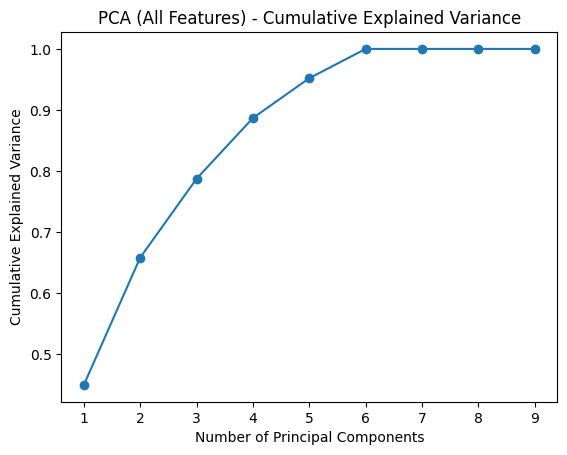


PCA Loadings (All Features):
                 PC1       PC2       PC3       PC4       PC5       PC6  \
high        0.496387  0.005685 -0.034677  0.049601 -0.004038  0.003393   
low         0.496469  0.006155 -0.032660  0.047368 -0.004334  0.003767   
open        0.496421  0.005201 -0.034858  0.047936 -0.005258  0.003146   
close       0.496425  0.006439 -0.033175  0.049055 -0.003400  0.003917   
Volume BTC -0.118313 -0.002758 -0.498025  0.849044 -0.101073  0.082882   
roc_4h     -0.000163  0.400997  0.546233  0.368758  0.590252  0.237586   
roc_24h    -0.002313  0.540587  0.327995  0.170867 -0.585041 -0.478237   
roc_7days  -0.007384  0.572830 -0.269791 -0.254712 -0.255917  0.684582   
roc_30days -0.013763  0.467639 -0.518313 -0.199148  0.483266 -0.489152   

                 PC7       PC8       PC9  
high       -0.633918 -0.121105  0.577373  
low         0.755343  0.087398  0.414675  
open       -0.161208  0.715853 -0.459952  
close       0.040148 -0.682089 -0.532099  
Volume BTC  0.

In [13]:
# 2. PCA on ALL FEATURES
# Create a DataFrame with just the columns of interest and drop NAs
X_all = df[all_features].dropna()

# 2.1 Standardize the data
scaler_all = StandardScaler()
X_all_scaled = scaler_all.fit_transform(X_all)

# 2.2 Run PCA (let n_components=None to get all components)
pca_all = PCA()
pca_all.fit(X_all_scaled)

# 2.3 Explained variance ratio
explained_variances_all = pca_all.explained_variance_ratio_
cumulative_variances_all = np.cumsum(explained_variances_all)

print("\n=== PCA on ALL FEATURES ===")
print("Explained Variance Ratio (per PC):", explained_variances_all)
print("Cumulative Explained Variance:", cumulative_variances_all)

# 2.4 Plot cumulative explained variance
plt.figure()
plt.plot(
    range(1, len(explained_variances_all) + 1),
    cumulative_variances_all,
    marker='o'
)
plt.title('PCA (All Features) - Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# 2.5 PCA loadings (how original features map to each principal component)
loadings_all = pd.DataFrame(
    pca_all.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca_all.components_))],
    index=X_all.columns
)
print("\nPCA Loadings (All Features):")
print(loadings_all)

In [ ]:
'''For PC1, the loadings on high, low, open, and close are all around +0.496.

This means PC1 is essentially the average price level across those four columns (they are highly correlated).

Volume BTC and the roc_* features contribute almost nothing to PC1.

Why? Because high, low, open, and close all move together (when price goes up, they all go up), so one “dimension” can represent that overall level.'
--------------------------------------

Looking at the loadings:

PC2 has large positive loadings on your roc_4h, roc_24h, roc_7days, and roc_30days, and almost no influence from the price columns.

This indicates PC2 is a “trend” or “momentum” dimension, mostly driven by your rate-of-change (ROC) features.

PC3 and PC4 also mix in your roc_* columns but start to incorporate Volume BTC heavily (notice negative or positive loadings of significant magnitude).

So these components seem to capture a combination of momentum and volume fluctuations.


PCs 7, 8, and 9 Add Almost No Extra Variance


'''

In [ ]:
''''
High Correlation Among Price Columns

Since high, low, open, and close cluster strongly, you could potentially drop or combine some of them if you only need a lean set of features (unless your downstream model exploits subtle differences among them).

Distinct “Momentum” Dimension

The rate-of-change features (roc_4h, roc_24h, etc.) clearly capture a separate dimension from raw prices. This suggests they’re adding unique information—useful for forecasting models that rely on momentum signals.

Volume Has Its Own Influence

Volume BTC is prominent in PC3/PC4, meaning it intersects with momentum in some interesting ways—but it does not strongly align with the core “price level” dimension.

Possible Dimensionality Reduction

If you want to reduce from 9 columns to fewer, your first 5 or 6 principal components already capture virtually 100% of the variance.

Alternatively, you might just keep 2–3 PCs if you only need to preserve 80–90% of the variance for, say, a simpler downstream analysis.

However, in predictive modeling, always confirm whether PCA-based reduction actually improves your forecasting performance—some nonlinear models can still benefit from having original features.'
'''


=== PCA on ONLY TREND FEATURES ===
Explained Variance Ratio (per PC): [0.46959517 0.27380158 0.14785254 0.10875071]
Cumulative Explained Variance: [0.46959517 0.74339675 0.89124929 1.        ]


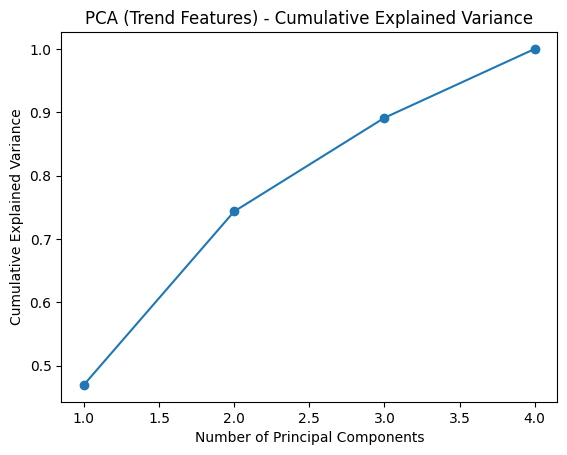


PCA Loadings (Trend Features):
                 PC1       PC2       PC3       PC4
roc_4h      0.400680  0.647172  0.602389  0.240312
roc_24h     0.540366  0.376306 -0.565679 -0.496393
roc_7days   0.572968 -0.344750 -0.284742  0.686861
roc_30days  0.468154 -0.566312  0.485856 -0.473356


In [14]:
# 3. PCA on ONLY the NEW (Trend) FEATURES
X_trend = df[trend_features].dropna()

# 3.1 Standardize the trend data
scaler_trend = StandardScaler()
X_trend_scaled = scaler_trend.fit_transform(X_trend)

# 3.2 Run PCA
pca_trend = PCA()
pca_trend.fit(X_trend_scaled)

# 3.3 Explained variance ratio
explained_variances_trend = pca_trend.explained_variance_ratio_
cumulative_variances_trend = np.cumsum(explained_variances_trend)

print("\n=== PCA on ONLY TREND FEATURES ===")
print("Explained Variance Ratio (per PC):", explained_variances_trend)
print("Cumulative Explained Variance:", cumulative_variances_trend)

# 3.4 Plot cumulative explained variance for trend features only
plt.figure()
plt.plot(
    range(1, len(explained_variances_trend) + 1),
    cumulative_variances_trend,
    marker='o'
)
plt.title('PCA (Trend Features) - Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# 3.5 PCA loadings for trend features
loadings_trend = pd.DataFrame(
    pca_trend.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca_trend.components_))],
    index=X_trend.columns
)
print("\nPCA Loadings (Trend Features):")
print(loadings_trend)

### Statistical analysis


In [4]:
# %% 0️⃣  COMMON SETUP  ──────────────────────────────────────────────────
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import lilliefors

sns.set_theme(style="whitegrid")
CSV = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version.csv")

# read & make a timestamp if missing
df_raw = pd.read_csv(CSV)
if "timestamp" not in df_raw.columns:
    df_raw["timestamp"] = pd.date_range("2015-10-08 14:00", periods=len(df_raw), freq="H")
df_raw.set_index("timestamp", inplace=True)

price = df_raw["close"].astype(float).values   # numpy for speed


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22316\4096993805.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_raw["timestamp"] = pd.date_range("2015-10-08 14:00", periods=len(df_raw), freq="H")


Formal tests — raw price
  Lilliefors   D = 0.197   p = 0.001
  Shapiro-Wilk W = 0.836   p = 6.2e-58
  D’Agostino K² = 14603.8    p = 0


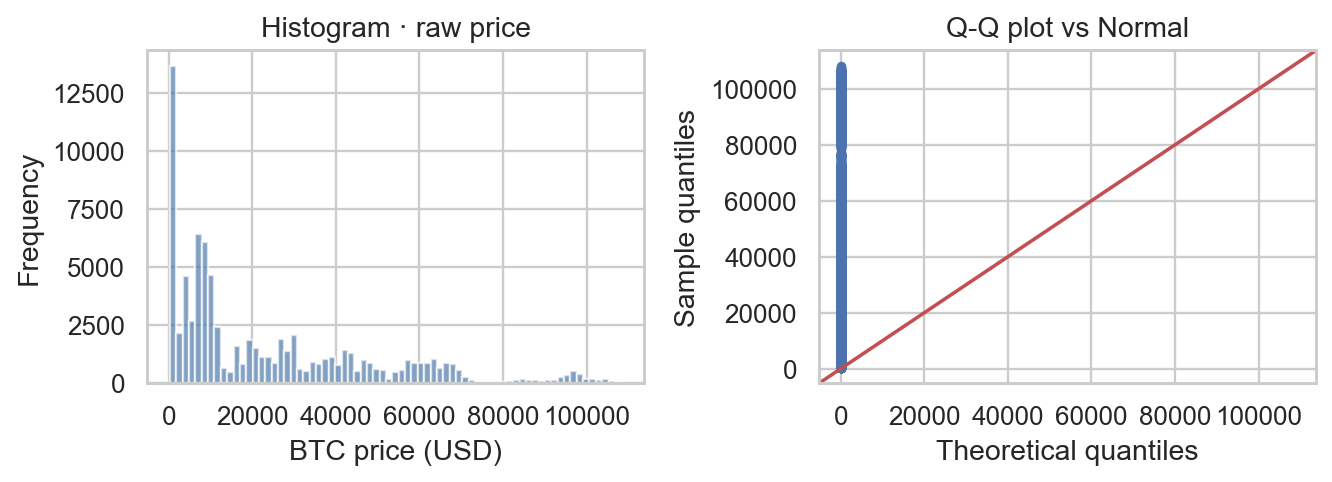

In [13]:
# %% 1️⃣  RAW PRICE • Normality check  (spoiler: NOT normal)
fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=170)

# ── histogram ──────────────────────────────────────────────────────────
ax[0].hist(price, bins="auto", color="#4C78A8", alpha=.7)
ax[0].set_title("Histogram · raw price")
ax[0].set_xlabel("BTC price (USD)")
ax[0].set_ylabel("Frequency")

# ── Q-Q plot ────────────────────────────────────────────────────────────
qqplot(price, line="45", ax=ax[1], marker=".", alpha=.5)
ax[1].set_title("Q-Q plot vs Normal")
ax[1].set_xlabel("Theoretical quantiles")
ax[1].set_ylabel("Sample quantiles")

# ── formal tests ───────────────────────────────────────────────────────
ks, p_ks = lilliefors(price)
w,  p_sw = stats.shapiro(np.random.choice(price, 5000, replace=False))
k2, p_k2 = stats.normaltest(price)

print("Formal tests — raw price")
print(f"  Lilliefors   D = {ks:.3f}   p = {p_ks:.2g}")
print(f"  Shapiro-Wilk W = {w :.3f}   p = {p_sw:.2g}")
print(f"  D’Agostino K² = {k2:.1f}    p = {p_k2:.2g}")

plt.tight_layout(); plt.show()


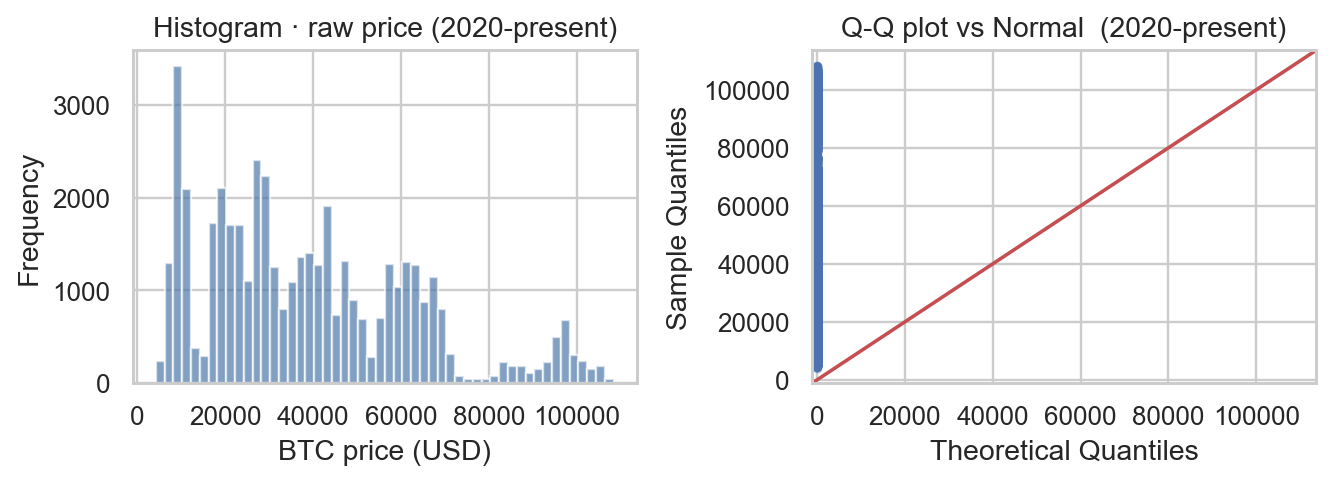

In [12]:

# %%  Histogram + Q-Q  •  raw price  (2018-present)  ─────────────────────
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

df_18 = df.loc["2020":]          # df was built in the earlier cell
price_18 = df_18["close"].astype(float).values

fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=170)

# histogram
ax[0].hist(price_18, bins="auto", color="#4C78A8", alpha=.7)
ax[0].set_title("Histogram · raw price (2020-present)")
ax[0].set_xlabel("BTC price (USD)"); ax[0].set_ylabel("Frequency")

# Q-Q plot
qqplot(price_18, line="45", ax=ax[1], marker=".", alpha=.5)
ax[1].set_title("Q-Q plot vs Normal  (2020-present)")

plt.tight_layout(); plt.show()



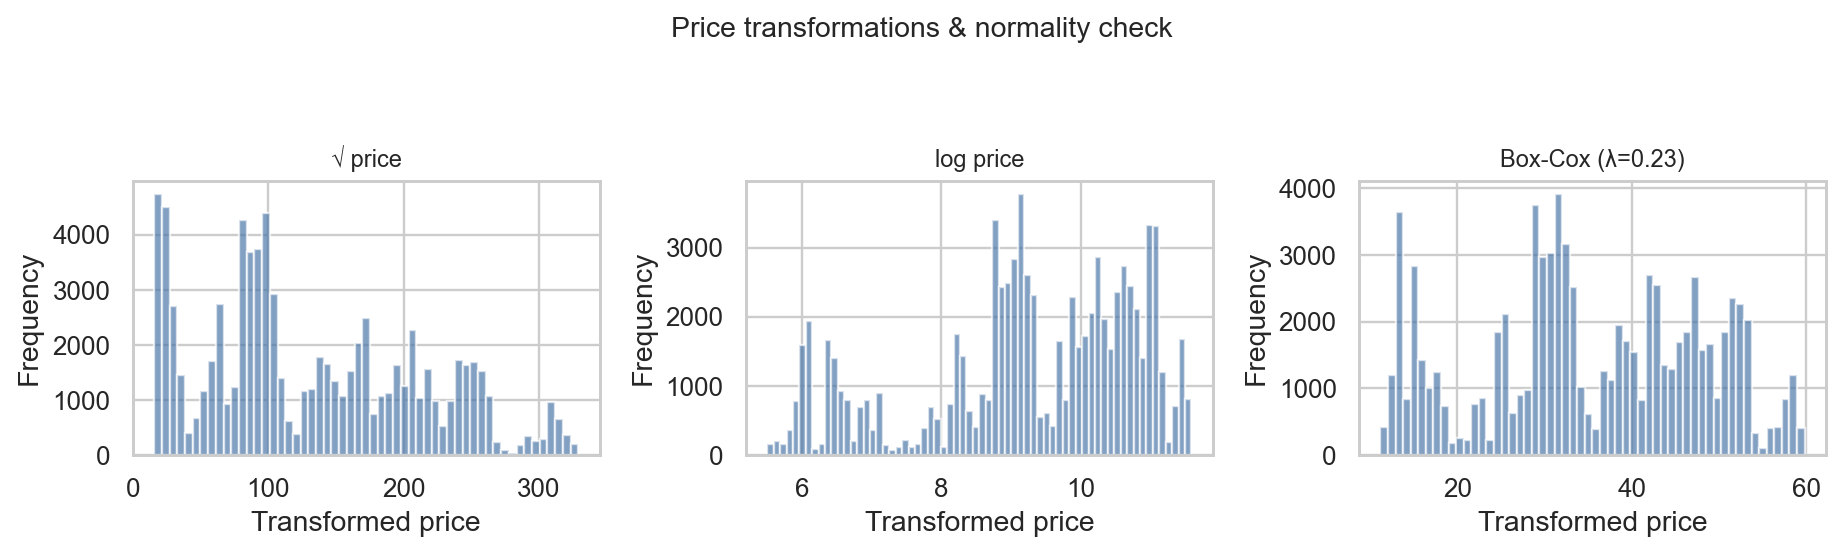

p-values for three formal normality tests
            KS-Lil     Shapiro     D’Agostino
√ price   :   0.001   8.22e-40             0
log price :   0.001   2.09e-44             0
Box-Cox   :   0.001    1.1e-33             0

Box-Cox formula:
  y(λ) = (x^λ – 1) / λ      if λ ≠ 0
  y(λ) = ln(x)              if λ = 0


In [9]:
# %% 2️⃣  TRANSFORMATIONS (√, log, Box-Cox)  + normality tests + histograms
from statsmodels.stats.diagnostic import lilliefors

def norm_report(data, label, ax):
    """Plot histogram and return (KS-Lilliefors, Shapiro, D’Agostino) p-values."""
    ks, p_ks = lilliefors(data)
    w,  p_sw = stats.shapiro(np.random.choice(data, min(5000, len(data)), replace=False))
    k2, p_k2 = stats.normaltest(data)

    ax.hist(data, bins="auto", alpha=.7, color="#4C78A8")
    ax.set_title(label, fontsize=10)
    ax.set_xlabel("Transformed price")
    ax.set_ylabel("Frequency")

    return p_ks, p_sw, p_k2

fig, axes = plt.subplots(1, 3, figsize=(11, 3), dpi=170)

pvals_sqrt = norm_report(np.sqrt(price), "√ price", axes[0])
pvals_log  = norm_report(np.log(price[price > 0]), "log price", axes[1])

price_pos = price[price > 0]                   # Box-Cox needs x > 0
price_bc, lam = stats.boxcox(price_pos)
pvals_bc  = norm_report(price_bc, f"Box-Cox (λ={lam:.2f})", axes[2])

plt.suptitle("Price transformations & normality check", y=1.08, fontsize=12)
plt.tight_layout(); plt.show()

print("p-values for three formal normality tests")
print("            KS-Lil     Shapiro     D’Agostino")
print(f"√ price   : {pvals_sqrt[0]:7.3g}  {pvals_sqrt[1]:9.3g}  {pvals_sqrt[2]:12.3g}")
print(f"log price : {pvals_log[0]:7.3g}  {pvals_log[1]:9.3g}  {pvals_log[2]:12.3g}")
print(f"Box-Cox   : {pvals_bc[0]:7.3g}  {pvals_bc[1]:9.3g}  {pvals_bc[2]:12.3g}")

print("\nBox-Cox formula:")
print("  y(λ) = (x^λ – 1) / λ      if λ ≠ 0")
print("  y(λ) = ln(x)              if λ = 0")


## K means 


In [ ]:
!pip install statsmodels

In [ ]:
CSV  = r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version.csv"


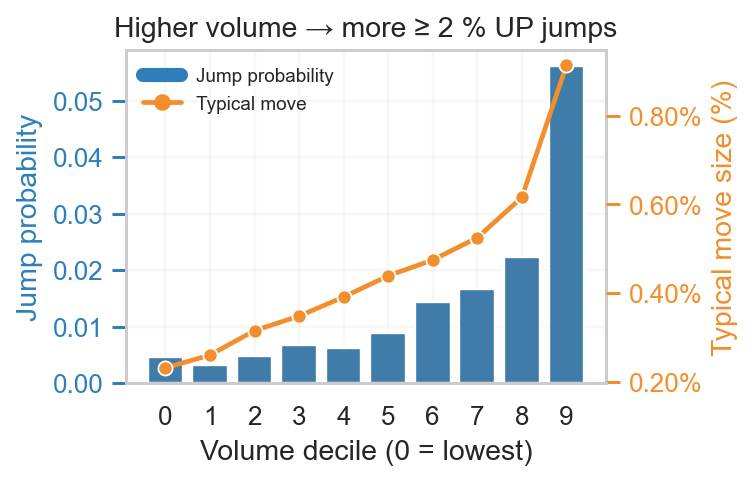

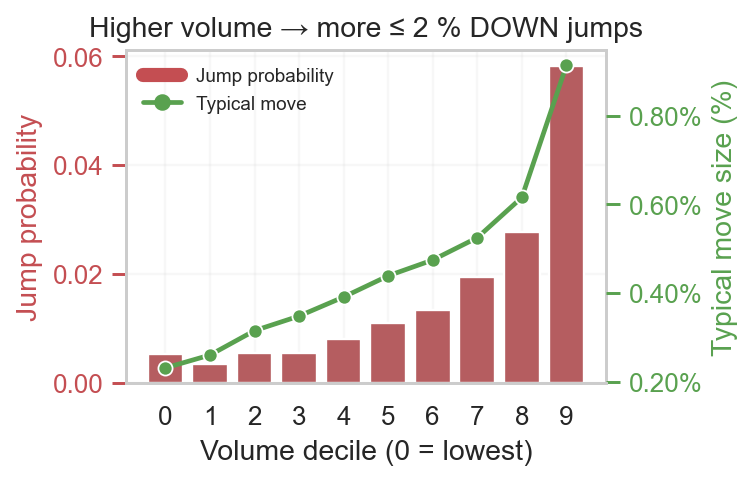

In [3]:
# %% 📊  Up- vs Down-jump probability by volume decile  ──────────────────
CSV_PATH   = r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version.csv"
START_TS   = "2015-10-08 14:00:00"   # first row’s hour if file lacks dates
PRICE_COL  = "close"
VOL_COL    = "Volume BTC"
THRESH_PCT = 0.02                    # jump ≥ 2 %
N_DECILES  = 10
LOOK_AHEAD = 1                       # next hour

import pandas as pd, numpy as np, re, seaborn as sns, matplotlib.pyplot as plt
import matplotlib.ticker as mtick
sns.set_theme(style="whitegrid")

# ── 1. load CSV & build timestamp index if missing ─────────────────────
raw = pd.read_csv(CSV_PATH)
date_col = next((c for c in raw.columns if re.search(r"(date|time|stamp)", c, re.I)), None)

if date_col:
    raw[date_col] = pd.to_datetime(raw[date_col], errors="coerce")
    df = (raw.dropna(subset=[date_col])
              .set_index(date_col)
              .sort_index())
else:
    df = raw.set_index(
        pd.date_range(START_TS, periods=len(raw), freq="H")
    )

# ── 2. feature engineering ─────────────────────────────────────────────
df["pct_move"] = df[PRICE_COL].shift(-LOOK_AHEAD).div(df[PRICE_COL]).sub(1)
df.dropna(subset=["pct_move"], inplace=True)

df["up_jump"]   = df["pct_move"] >=  THRESH_PCT
df["down_jump"] = df["pct_move"] <= -THRESH_PCT
df["abs_move"]  = df["pct_move"].abs()
df["log_vol"]   = np.log(df[VOL_COL].clip(lower=1e-12))

# ── 3. decile stats helper ─────────────────────────────────────────────
def make_table(flag):
    dec = pd.qcut(df["log_vol"], N_DECILES, labels=False)
    return (df.assign(decile=dec)
              .groupby("decile", observed=True)
              .agg(jump_prob = (flag, "mean"),
                   avg_move  = ("abs_move", "mean"))
              .reset_index())

tab_up   = make_table("up_jump")
tab_down = make_table("down_jump")

# ── 4. plotting helper ─────────────────────────────────────────────────
def plot_deciles(tbl, title, bar_c, line_c):
    fig, ax1 = plt.subplots(figsize=(4.6,3), dpi=170)
    ax2 = ax1.twinx()

    sns.barplot(x="decile", y="jump_prob", data=tbl,
                color=bar_c, edgecolor="white", ax=ax1, zorder=2)
    sns.lineplot(x="decile", y="avg_move", data=tbl,
                 marker="o", lw=2, color=line_c, ax=ax2, zorder=3)

    ax1.set_xlabel("Volume decile (0 = lowest)")
    ax1.set_ylabel("Jump probability", color=bar_c)
    ax2.set_ylabel("Typical move size (%)", color=line_c)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))

    ax1.grid(alpha=.15); ax2.grid(False)
    ax2.spines["right"].set_visible(False); ax1.spines["top"].set_visible(False)
    ax1.tick_params(axis="y", colors=bar_c); ax2.tick_params(axis="y", colors=line_c)

    ax1.plot([],[], lw=6, color=bar_c, label="Jump probability")
    ax1.plot([],[], lw=2, marker="o", color=line_c, label="Typical move")
    ax1.legend(frameon=False, fontsize=8, loc="upper left")
    ax1.set_title(title, pad=6)

    plt.tight_layout(); plt.show()

# ── 5. draw the two charts ─────────────────────────────────────────────
plot_deciles(tab_up,
             "Higher volume → more ≥ 2 % UP jumps",
             bar_c="#2E7EBB", line_c="#F28E2B")

plot_deciles(tab_down,
             "Higher volume → more ≤ 2 % DOWN jumps",
             bar_c="#C44E52", line_c="#59A14F")



🪙  12 BTC falls in **decile 2** (9 – 17 BTC)
   • Up-jump ≥ 2 % chance  : 0.48%
   • Down-jump ≥ 2 % chance: 0.55%
   • Typical |move| next h : 0.32%


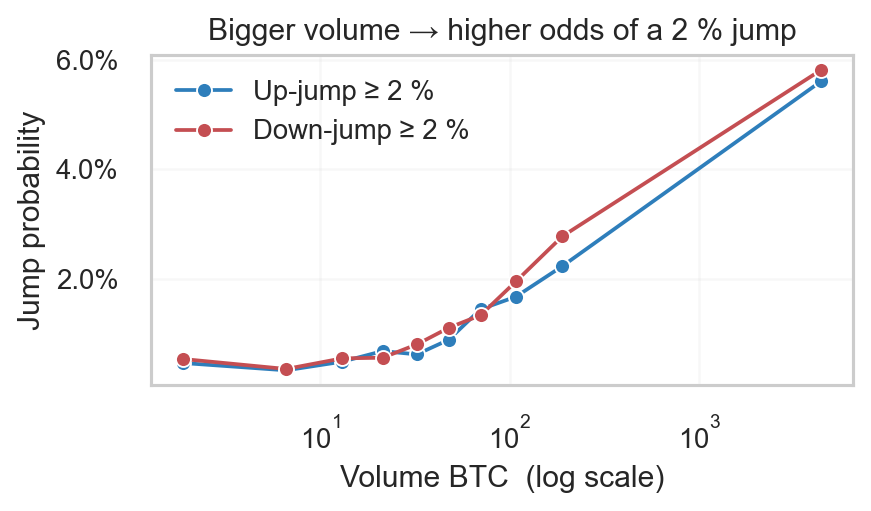

In [114]:
# %% 📊  Volume-→-Jump risk toolkit  ───────────────────────────────────────
THRESH_PCT       = 0.02          # 2 % jump threshold
N_DECILES        = 10            # equal-count bins
LOOK_AHEAD_HRS   = 1             # next-hour move

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import matplotlib.ticker as mtick

# ─────────────────────────────────────────────────────────────────────────
def build_jump_stats(df_raw: pd.DataFrame) -> pd.DataFrame:
    """Return a decile-wise table with up-prob, down-prob & avg move."""
    df = df_raw.copy()

    # ▲ 1. next-hour % move (signed) -------------------------
    fwd_close = df["close"].shift(-LOOK_AHEAD_HRS)
    df["pct_move"] = fwd_close.div(df["close"]).sub(1)
    df.dropna(subset=["pct_move"], inplace=True)

    # ▲ 2. flags & helpers ----------------------------------
    df["up_jump"]   = df["pct_move"] >=  THRESH_PCT
    df["down_jump"] = df["pct_move"] <= -THRESH_PCT
    df["abs_move"]  = df["pct_move"].abs()
    df["log_vol"]   = np.log(df["Volume BTC"].clip(lower=1e-12))

    # ▲ 3. decile summary -----------------------------------
    dec = pd.qcut(df["log_vol"], N_DECILES, labels=False)
    stats = (df.assign(decile=dec)
               .groupby("decile", observed=True)
               .agg(vol_min   = ("Volume BTC", "min"),
                    vol_max   = ("Volume BTC", "max"),
                    up_prob   = ("up_jump"  , "mean"),
                    down_prob = ("down_jump", "mean"),
                    avg_move  = ("abs_move" , "mean"))
               .reset_index())
    return stats

# build once
jump_stats = build_jump_stats(df)   # df is your original price/volume DataFrame

# ─────────────────────────────────────────────────────────────────────────
def volume_report(volume_btc: float, fancy: bool = True):
    """Print & return risk stats for a given raw volume."""
    r = jump_stats.loc[(jump_stats.vol_min <= volume_btc) &
                       (volume_btc <= jump_stats.vol_max)]
    if r.empty:                         # above last bin → use last row
        r = jump_stats.tail(1)
    r = r.squeeze()                     # turn 1-row DF → Series

    out = dict(
        Decile          = int(r.decile),
        Volume_range    = f"{r.vol_min:,.0f} – {r.vol_max:,.0f} BTC",
        Up_jump_prob    = r.up_prob,
        Down_jump_prob  = r.down_prob,
        Avg_abs_move    = r.avg_move,
    )

    if fancy:
        print(f"\n🪙  {volume_btc:,.0f} BTC falls in **decile {out['Decile']}** "
              f"({out['Volume_range']})")
        print(f"   • Up-jump ≥ 2 % chance  : {out['Up_jump_prob']:.2%}")
        print(f"   • Down-jump ≥ 2 % chance: {out['Down_jump_prob']:.2%}")
        print(f"   • Typical |move| next h : {out['Avg_abs_move']:.2%}")
    return out

# ─────────────────────────────────────────────────────────────────────────
def plot_jump_curves():
    """Single figure: up & down jump probability vs. volume decile."""
    tbl = jump_stats.copy()
    tbl["mid_vol"] = (tbl.vol_min + tbl.vol_max) / 2

    fig, ax = plt.subplots(figsize=(5,3), dpi=180)
    sns.lineplot(x="mid_vol", y="up_prob",   data=tbl,
                 marker="o", label="Up-jump ≥ 2 %", color="#2E7EBB", ax=ax)
    sns.lineplot(x="mid_vol", y="down_prob", data=tbl,
                 marker="o", label="Down-jump ≥ 2 %", color="#C44E52", ax=ax)

    ax.set_xscale("log")
    ax.set_xlabel("Volume BTC  (log scale)")
    ax.set_ylabel("Jump probability")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax.set_title("Bigger volume → higher odds of a 2 % jump")
    ax.grid(alpha=.15)
    ax.legend()
    plt.tight_layout(); plt.show()

# ─── quick demo ──────────────────────────────────────────────────────────
_ = volume_report(12)          # example lookup
plot_jump_curves()             # curves figure


In [1]:
# %%  TABLE: volume → jump risk  (FULL DATA, jump ≥ 1 %)  ────────────────
CSV_PATH   = r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version.csv"
START_TS   = "2015-10-08 14:00:00"     # first row’s hour if file lacks timestamps
PRICE_COL  = "close"
VOL_COL    = "Volume BTC"
THRESH_PCT = 0.02                      # 1 % jump threshold
N_DECILES  = 10

import pandas as pd, numpy as np, re

# ── load CSV & attach a timestamp index if needed ───────────────────────
raw = pd.read_csv(CSV_PATH)

date_col = next((c for c in raw.columns
                 if re.search(r"(date|time|stamp)", c, re.I)), None)

if date_col:
    raw[date_col] = pd.to_datetime(raw[date_col], errors="coerce")
    btc = (raw.dropna(subset=[date_col])
              .set_index(date_col)
              .sort_index())
else:  # build index hour-by-hour
    btc = raw.set_index(
        pd.date_range(START_TS, periods=len(raw), freq="H")
    )

# ── compute forward move & jump flag ────────────────────────────────────
btc["pct_move"] = btc[PRICE_COL].shift(-1).div(btc[PRICE_COL]).sub(1)   # signed %
btc.dropna(subset=["pct_move"], inplace=True)

btc["jump_flag"] = btc["pct_move"].abs() >= THRESH_PCT
btc["abs_move"]  = btc["pct_move"].abs()
btc["log_vol"]   = np.log(btc[VOL_COL].clip(lower=1e-12))

# ── decile table ────────────────────────────────────────────────────────
dec = pd.qcut(btc["log_vol"], N_DECILES, labels=False)
tbl = (btc.assign(decile=dec)
         .groupby("decile", observed=True)
         .agg(vol_min  =(VOL_COL,"min"),
              vol_max  =(VOL_COL,"max"),
              jump_prob=("jump_flag","mean"),
              avg_move =("abs_move","mean"))
         .reset_index())

tbl["Volume range"] = tbl.apply(
    lambda r: f"{r.vol_min:,.0f} – {r.vol_max:,.0f} BTC", axis=1)

result = (tbl[["Volume range","jump_prob","avg_move"]]
            .rename(columns={"jump_prob":"Jump ≥2% chance",
                             "avg_move"  :"Avg. move next hr"})
            .style.format({"Jump ≥2% chance":"{:.2%}",
                           "Avg. move next hr":"{:.2%}"}))

display(result)


,Volume range,Jump ≥2% chance,Avg. move next hr
0,0 – 4 BTC,0.99%,0.23%
1,4 – 9 BTC,0.68%,0.26%
2,9 – 17 BTC,1.03%,0.32%
3,17 – 26 BTC,1.24%,0.35%
4,26 – 39 BTC,1.42%,0.39%
5,39 – 57 BTC,1.99%,0.44%
6,57 – 84 BTC,2.78%,0.47%
7,84 – 132 BTC,3.62%,0.53%
8,132 – 247 BTC,5.00%,0.62%
9,"247 – 8,527 BTC",11.43%,0.91%


In [6]:
# %%  TABLE: volume → jump risk  (FULL DATA, jump ≥ 1 %)  ────────────────
CSV_PATH   = r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version.csv"
START_TS   = "2015-10-08 14:00:00"     # first row’s hour if file lacks timestamps
PRICE_COL  = "close"
VOL_COL    = "Volume BTC"
THRESH_PCT = 0.01                      # 1 % jump threshold
N_DECILES  = 10

import pandas as pd, numpy as np, re

# ── load CSV & attach a timestamp index if needed ───────────────────────
raw = pd.read_csv(CSV_PATH)

date_col = next((c for c in raw.columns
                 if re.search(r"(date|time|stamp)", c, re.I)), None)

if date_col:
    raw[date_col] = pd.to_datetime(raw[date_col], errors="coerce")
    btc = (raw.dropna(subset=[date_col])
              .set_index(date_col)
              .sort_index())
else:  # build index hour-by-hour
    btc = raw.set_index(
        pd.date_range(START_TS, periods=len(raw), freq="H")
    )

# ── compute forward move & jump flag ────────────────────────────────────
btc["pct_move"] = btc[PRICE_COL].shift(-1).div(btc[PRICE_COL]).sub(1)   # signed %
btc.dropna(subset=["pct_move"], inplace=True)

btc["jump_flag"] = btc["pct_move"].abs() >= THRESH_PCT
btc["abs_move"]  = btc["pct_move"].abs()
btc["log_vol"]   = np.log(btc[VOL_COL].clip(lower=1e-12))

# ── decile table ────────────────────────────────────────────────────────
dec = pd.qcut(btc["log_vol"], N_DECILES, labels=False)
tbl = (btc.assign(decile=dec)
         .groupby("decile", observed=True)
         .agg(vol_min  =(VOL_COL,"min"),
              vol_max  =(VOL_COL,"max"),
              jump_prob=("jump_flag","mean"),
              avg_move =("abs_move","mean"))
         .reset_index())

tbl["Volume range"] = tbl.apply(
    lambda r: f"{r.vol_min:,.0f} – {r.vol_max:,.0f} BTC", axis=1)

result = (tbl[["Volume range","jump_prob","avg_move"]]
            .rename(columns={"jump_prob":"Jump ≥1% chance",
                             "avg_move"  :"Avg. move next hr"})
            .style.format({"Jump ≥1% chance":"{:.2%}",
                           "Avg. move next hr":"{:.2%}"}))

display(result)


,Volume range,Jump ≥1% chance,Avg. move next hr
0,0 – 4 BTC,3.77%,0.23%
1,4 – 9 BTC,3.36%,0.26%
2,9 – 17 BTC,4.94%,0.32%
3,17 – 26 BTC,5.87%,0.35%
4,26 – 39 BTC,8.03%,0.39%
5,39 – 57 BTC,9.94%,0.44%
6,57 – 84 BTC,11.63%,0.47%
7,84 – 132 BTC,13.95%,0.53%
8,132 – 247 BTC,18.64%,0.62%
9,"247 – 8,527 BTC",30.15%,0.91%


In [ ]:
# %%  TABLE: volume → jump risk  (FULL DATA, jump ≥ 1 %)  ────────────────
CSV_PATH   = r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version.csv"
START_TS   = "2015-10-08 14:00:00"     # first row’s hour if file lacks timestamps
PRICE_COL  = "close"
VOL_COL    = "Volume BTC"
THRESH_PCT = 0.005                     # 0.005 % jump threshold
N_DECILES  = 10

import pandas as pd, numpy as np, re

# ── load CSV & attach a timestamp index if needed ───────────────────────
raw = pd.read_csv(CSV_PATH)

date_col = next((c for c in raw.columns
                 if re.search(r"(date|time|stamp)", c, re.I)), None)

if date_col:
    raw[date_col] = pd.to_datetime(raw[date_col], errors="coerce")
    btc = (raw.dropna(subset=[date_col])
              .set_index(date_col)
              .sort_index())
else:  # build index hour-by-hour
    btc = raw.set_index(
        pd.date_range(START_TS, periods=len(raw), freq="H")
    )

# ── compute forward move & jump flag ────────────────────────────────────
btc["pct_move"] = btc[PRICE_COL].shift(-1).div(btc[PRICE_COL]).sub(1)   # signed %
btc.dropna(subset=["pct_move"], inplace=True)

btc["jump_flag"] = btc["pct_move"].abs() >= THRESH_PCT
btc["abs_move"]  = btc["pct_move"].abs()
btc["log_vol"]   = np.log(btc[VOL_COL].clip(lower=1e-12))

# ── decile table ────────────────────────────────────────────────────────
dec = pd.qcut(btc["log_vol"], N_DECILES, labels=False)
tbl = (btc.assign(decile=dec)
         .groupby("decile", observed=True)
         .agg(vol_min  =(VOL_COL,"min"),
              vol_max  =(VOL_COL,"max"),
              jump_prob=("jump_flag","mean"),
              avg_move =("abs_move","mean"))
         .reset_index())

tbl["Volume range"] = tbl.apply(
    lambda r: f"{r.vol_min:,.0f} – {r.vol_max:,.0f} BTC", axis=1)

result = (tbl[["Volume range","jump_prob","avg_move"]]
            .rename(columns={"jump_prob":"Jump ≥0.5% chance",
                             "avg_move"  :"Avg. move next hr"})
            .style.format({"Jump ≥0.5% chance":"{:.2%}",
                           "Avg. move next hr":"{:.2%}"}))

display(result)

#“Given today’s trading volume, what’s the chance the magnitude of the next-hour move will be at least X %?”


,Volume range,Jump ≥0.5% chance,Avg. move next hr
0,0 – 4 BTC,10.70%,0.23%
1,4 – 9 BTC,13.16%,0.26%
2,9 – 17 BTC,17.49%,0.32%
3,17 – 26 BTC,20.86%,0.35%
4,26 – 39 BTC,24.90%,0.39%
5,39 – 57 BTC,28.61%,0.44%
6,57 – 84 BTC,31.66%,0.47%
7,84 – 132 BTC,34.08%,0.53%
8,132 – 247 BTC,40.78%,0.62%
9,"247 – 8,527 BTC",53.96%,0.91%


## Calculating clusters for groups of years , and doing 5 clusters insted of 9

In [5]:
# %%  Volume buckets (4 + split top) & multi‑jump stats  ────────────────
CSV = r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version.csv"
START_TS = "2015-10-08 14:00:00"
PRICE_COL, VOL_COL = "close", "Volume BTC"
THRESHES = [0.02, 0.01, 0.005]               # 2 %, 1 %, 0.5 %

import pandas as pd, numpy as np, re

raw = pd.read_csv(CSV)
date_col = next((c for c in raw.columns if re.search(r"(date|time|stamp)", c, re.I)), None)
if date_col:
    raw[date_col] = pd.to_datetime(raw[date_col]); raw.set_index(date_col, inplace=True)
else:
    raw.index = pd.date_range(START_TS, periods=len(raw), freq="H")

def summary(frame, label):
    f = frame.copy()
    f["pct_move"] = f[PRICE_COL].shift(-1).div(f[PRICE_COL]).sub(1)
    f.dropna(subset=["pct_move"], inplace=True)
    f["log_vol"]  = np.log(f[VOL_COL].clip(lower=1e-12))

    # 4 equal buckets on log‑vol
    q4 = pd.qcut(f["log_vol"], 4, labels=False)
    f["bucket"] = q4

    # split highest bucket at 1 000 BTC
    top_mask = f["bucket"] == 3
    very_hi  = f[top_mask & (f[VOL_COL] >= 1000)].index
    hi       = f[top_mask & (f[VOL_COL] < 1000)].index
    f.loc[very_hi, "bucket"] = 4        # new bucket

    # jump flags
    for t in THRESHES:
        f[f"jump_{t}"] = f["pct_move"].abs() >= t

    g = (f.groupby("bucket", observed=True)
           .agg(vol_min=(VOL_COL,"min"),
                vol_max=(VOL_COL,"max"),
                N      =("pct_move","size"),
                **{f"p_{t}":(f"jump_{t}","mean") for t in THRESHES})
           .reset_index())

    g["Volume range"] = g.apply(lambda r: f"{r.vol_min:,.0f} – {r.vol_max:,.0f}", axis=1)
    g = g.drop(columns=["vol_min","vol_max"]).rename(columns={"bucket":"Bucket"})
    g = g[["Bucket","Volume range","N",
           "p_0.02","p_0.01","p_0.005"]].rename(columns={
           "p_0.02":"Jump ≥2%","p_0.01":"Jump ≥1%","p_0.005":"Jump ≥0.5%"})

    print(f"\n=== {label} ===")
    display(g.style.format({"Jump ≥2%":"{:.2%}",
                            "Jump ≥1%":"{:.2%}",
                            "Jump ≥0.5%":"{:.2%}"}))

summary(raw.loc["2015":"2018"], "2015‑2018")
summary(raw.loc["2020":"2025"], "2020‑2025")
summary(raw.loc["2023":"2025"], "2023‑2025")



=== 2015‑2018 ===


,Bucket,Volume range,N,Jump ≥2%,Jump ≥1%,Jump ≥0.5%
0,0,0 – 20,6975,2.01%,6.57%,16.09%
1,1,20 – 82,6974,2.17%,8.10%,21.62%
2,2,82 – 222,6974,4.13%,14.45%,32.94%
3,3,"222 – 1,000",6232,9.13%,26.73%,50.53%
4,4,"1,002 – 8,527",743,20.86%,45.63%,64.06%



=== 2020‑2025 ===


,Bucket,Volume range,N,Jump ≥2%,Jump ≥1%,Jump ≥0.5%
0,0,0 – 11,11469,0.32%,2.21%,10.31%
1,1,11 – 28,11468,0.88%,5.69%,21.22%
2,2,28 – 65,11468,1.86%,10.34%,31.21%
3,3,65 – 999,11395,5.09%,19.17%,43.71%
4,4,"1,001 – 3,136",74,33.78%,51.35%,72.97%



=== 2023‑2025 ===


,Bucket,Volume range,N,Jump ≥2%,Jump ≥1%,Jump ≥0.5%
0,0,0 – 5,4897,0.14%,1.35%,6.68%
1,1,5 – 13,4896,0.43%,2.59%,12.79%
2,2,13 – 32,4896,0.94%,5.54%,20.92%
3,3,32 – 637,4896,2.68%,13.03%,35.87%


# Show lines of close

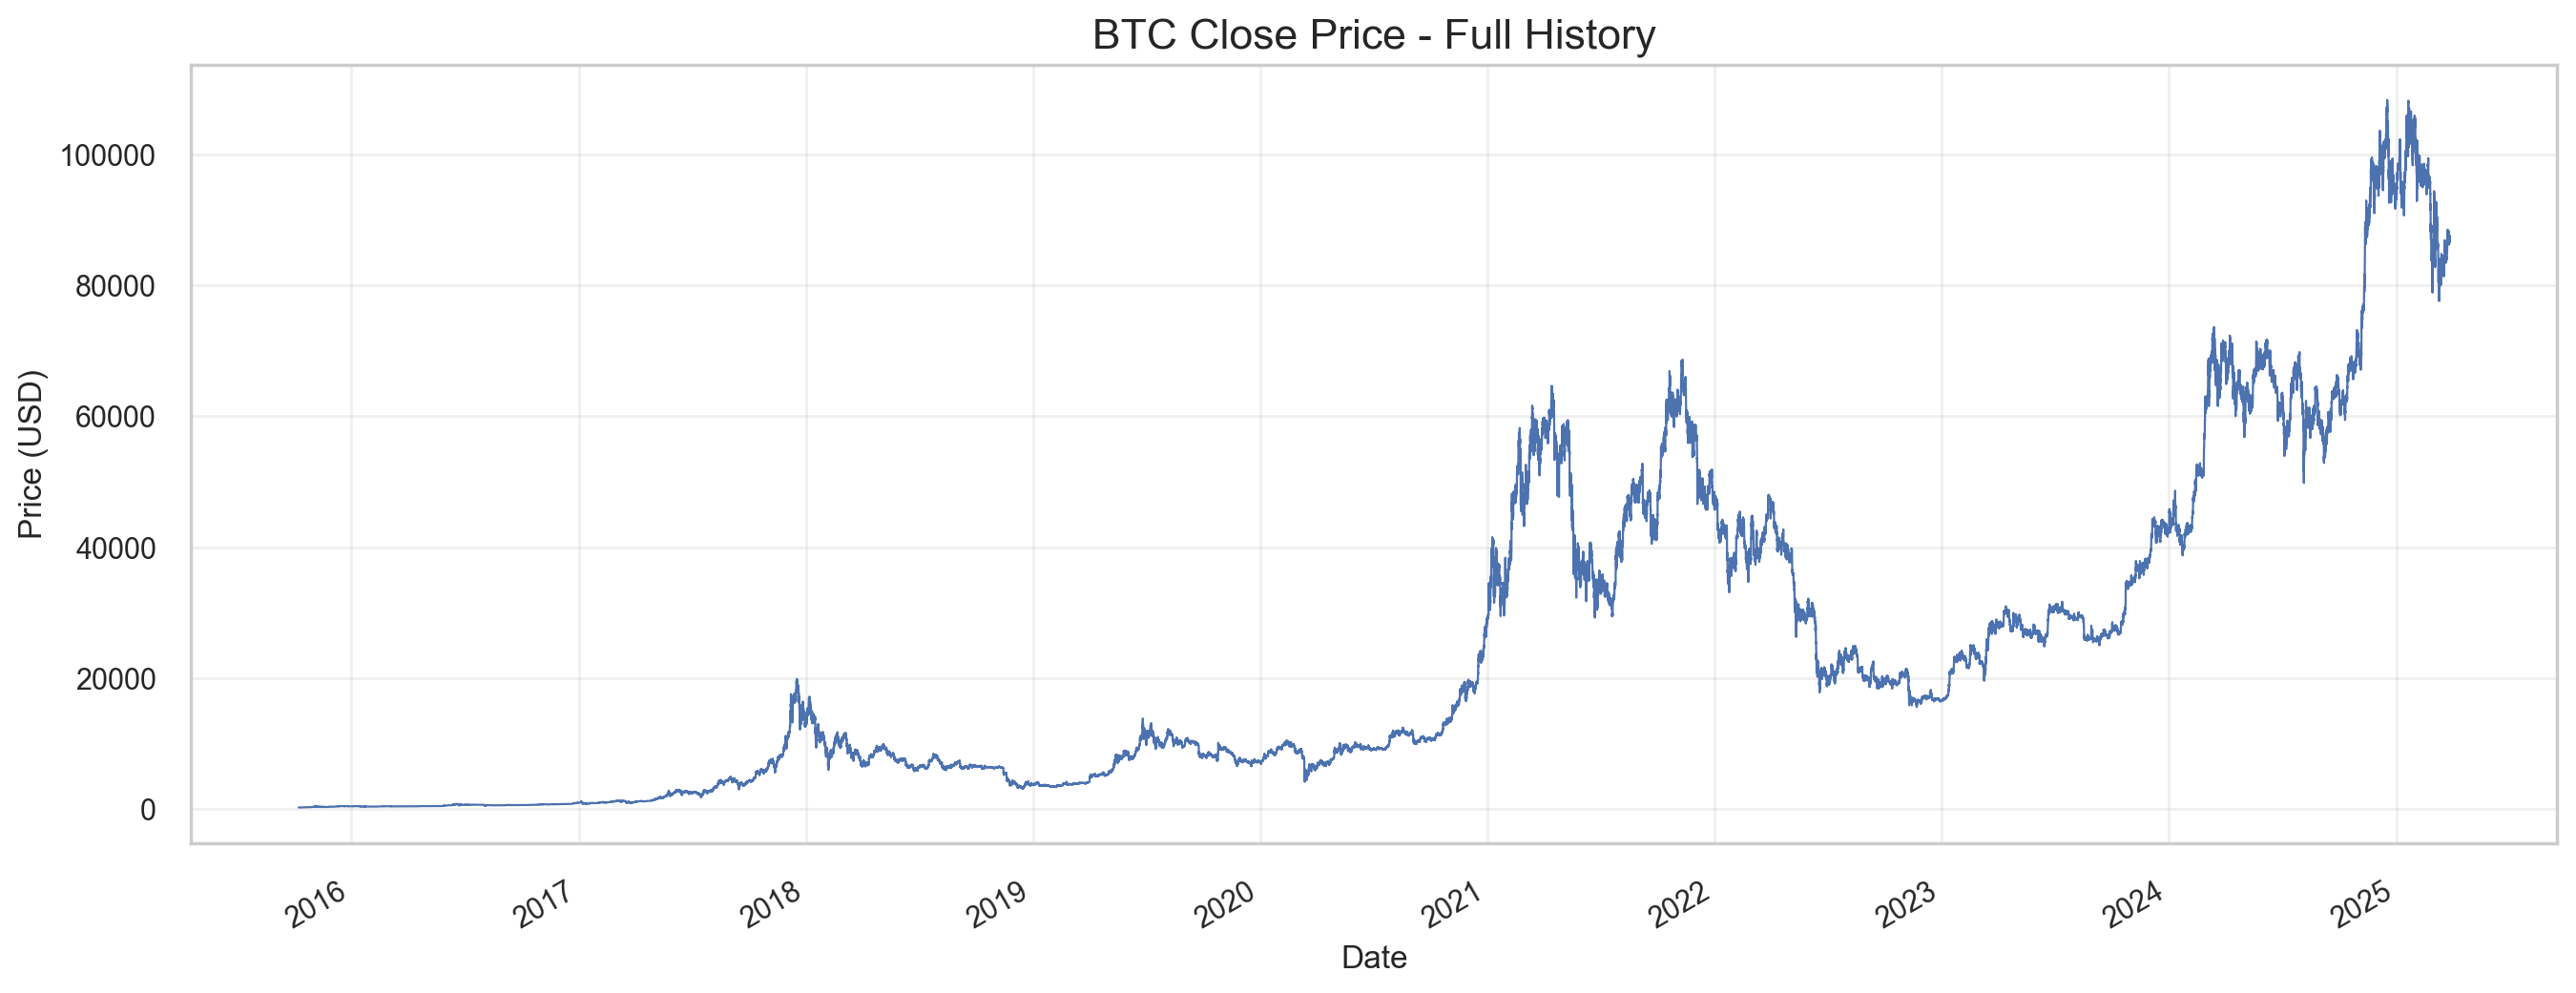

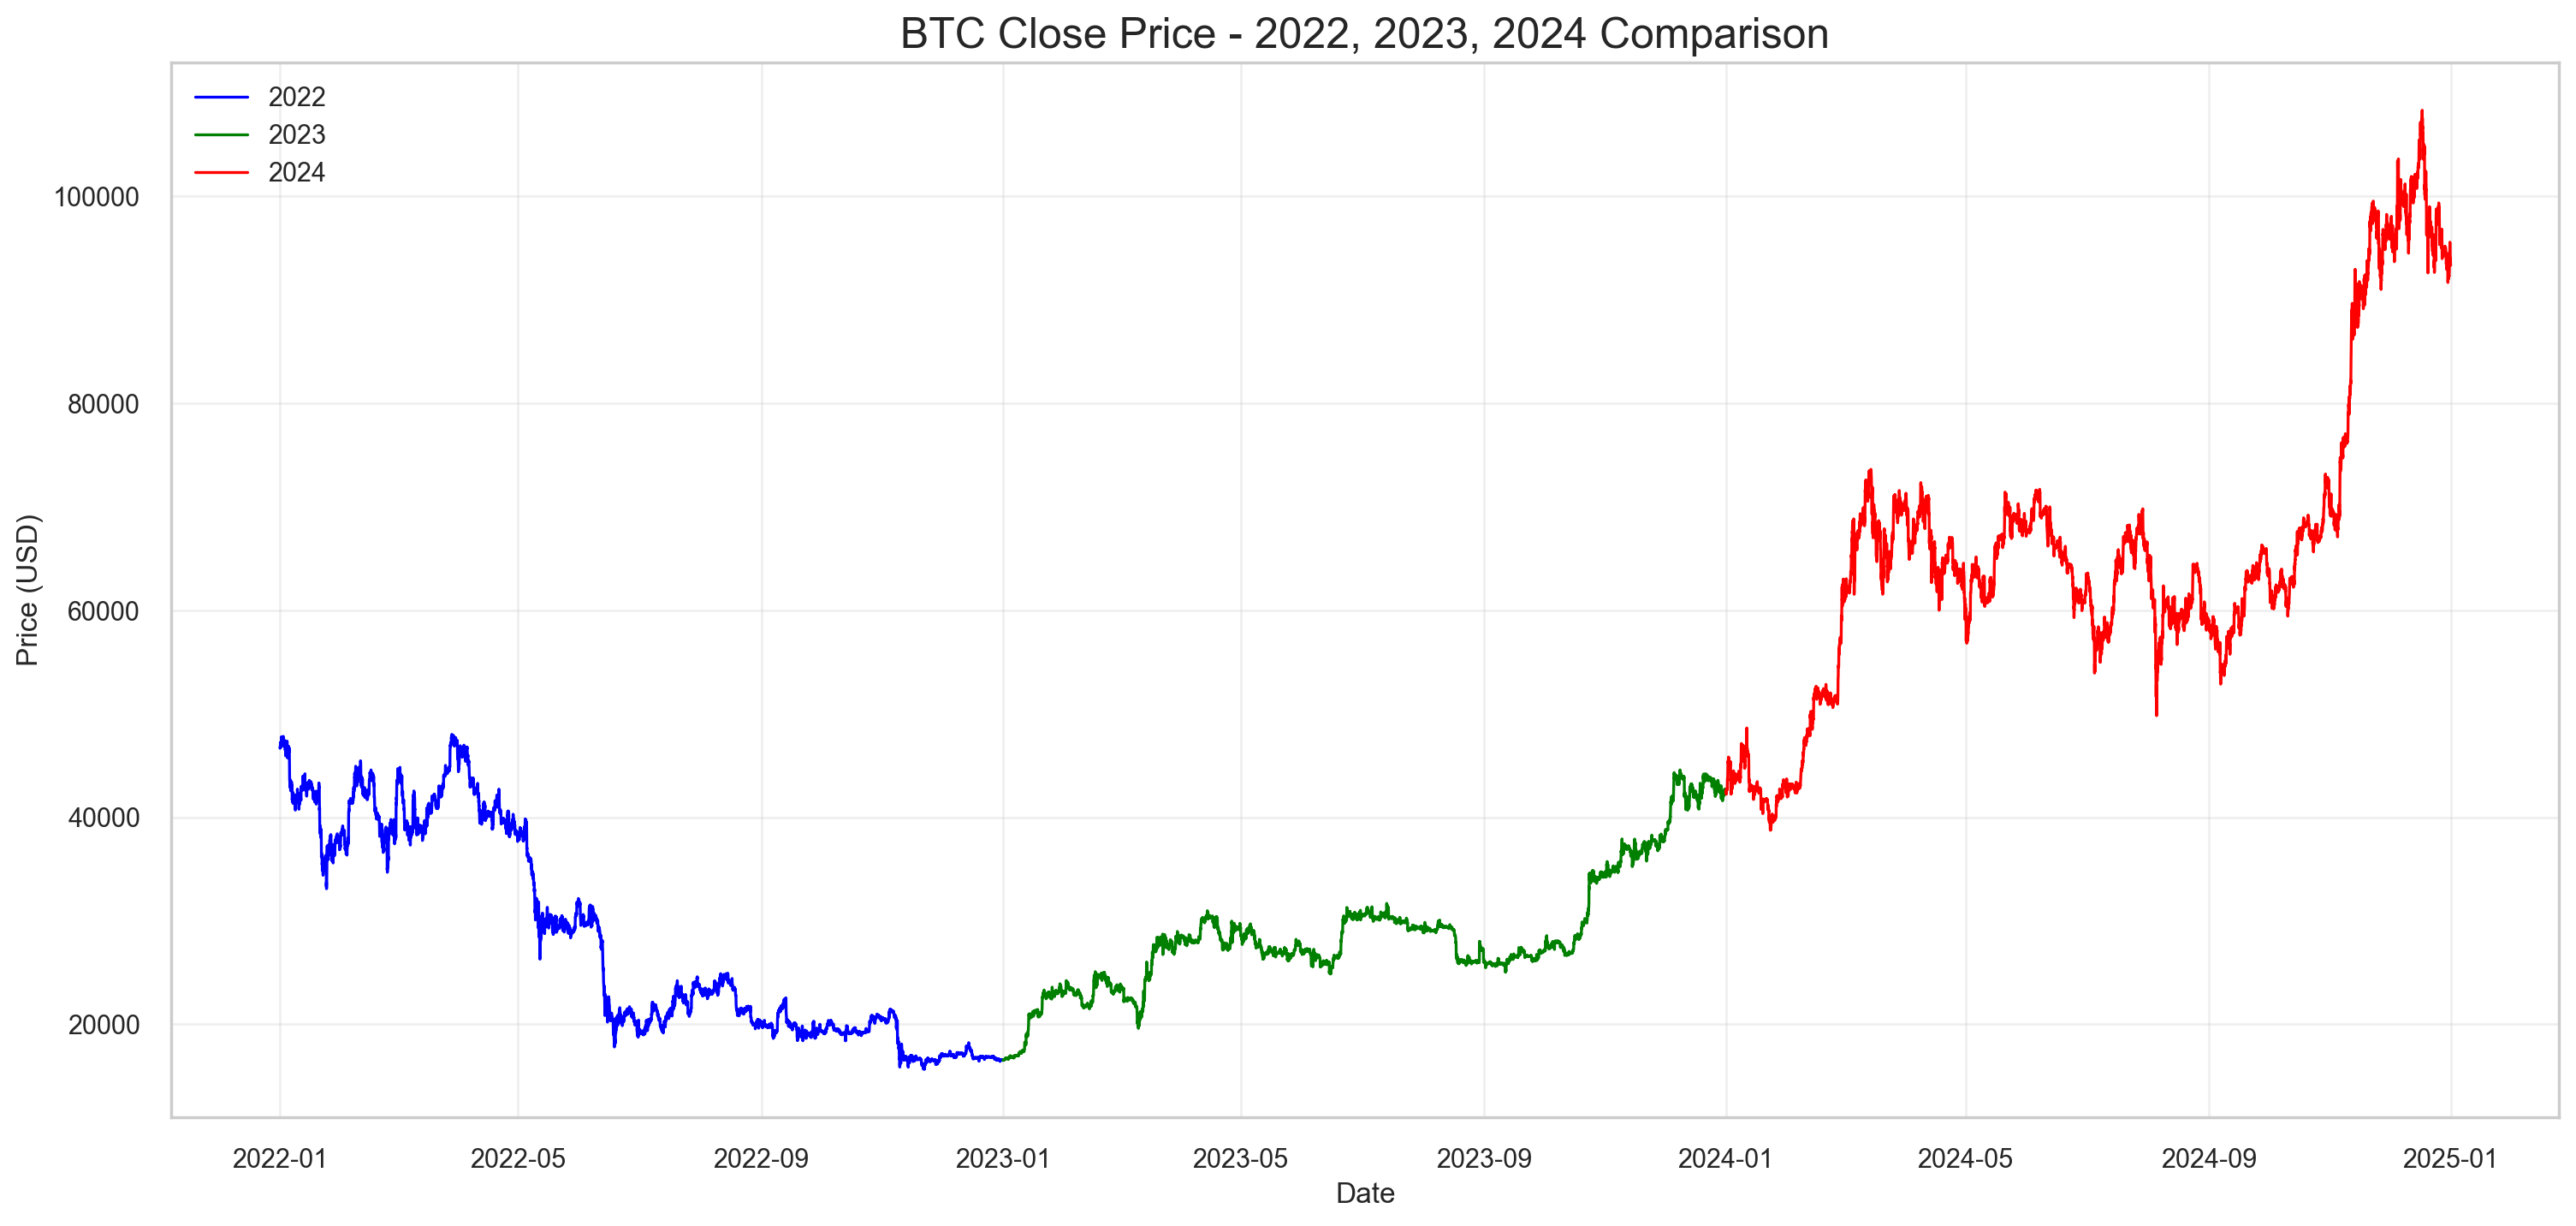

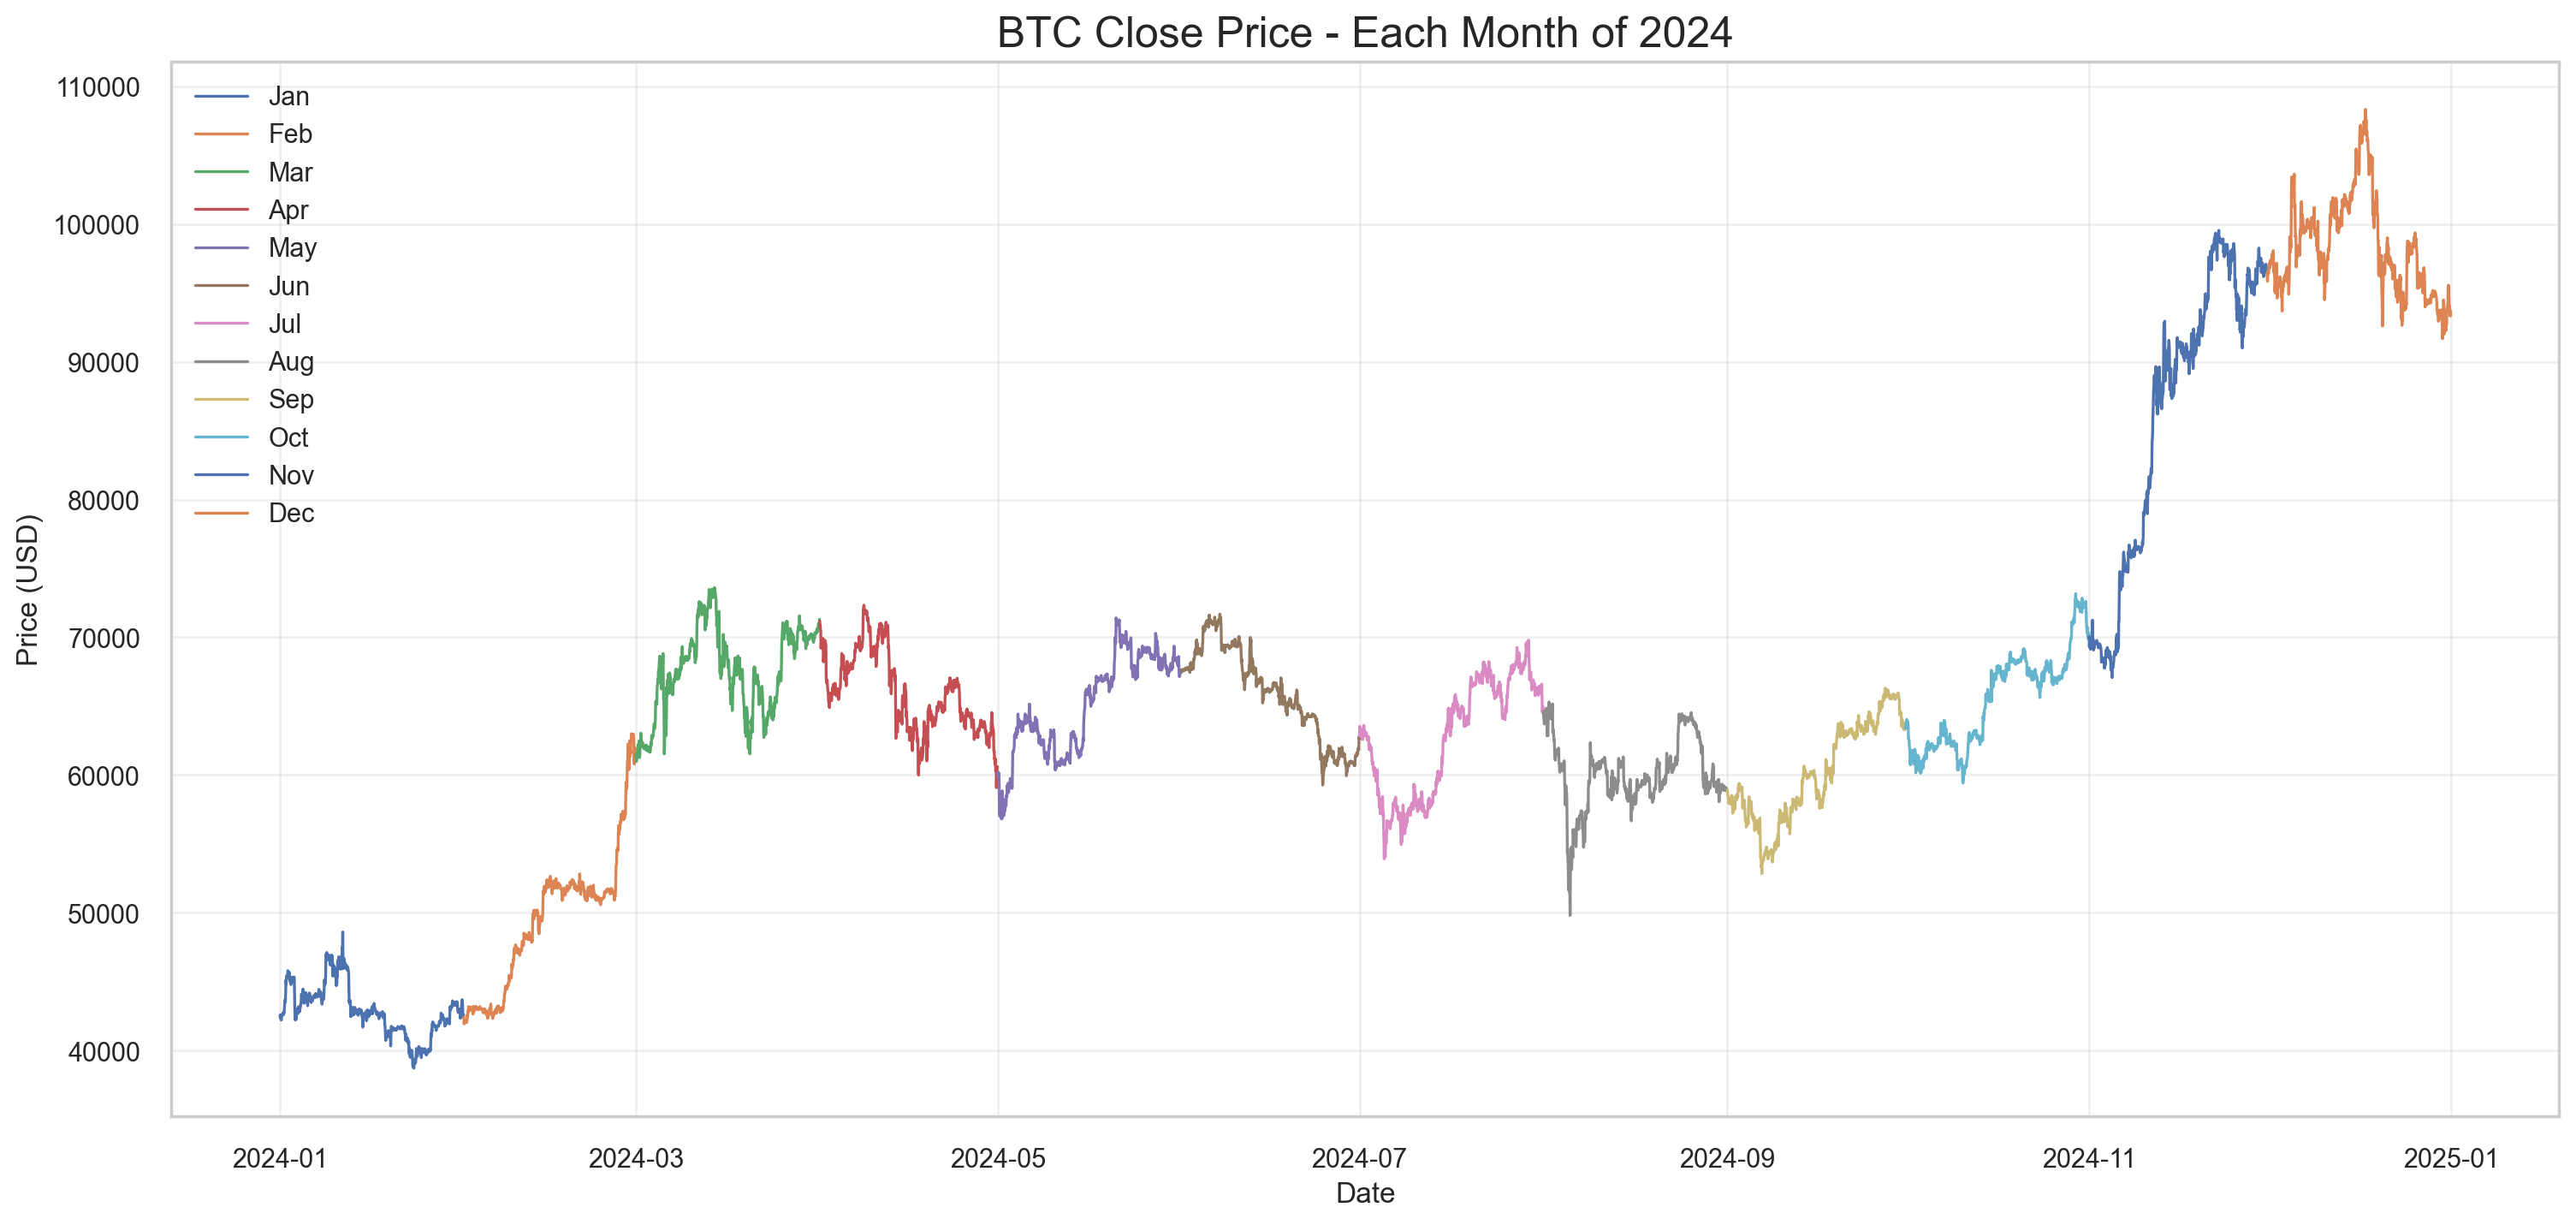

In [129]:
# 📈 BTC Price Comparison Visualization
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Load the data
file_path = r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version.csv"
btc = pd.read_csv(file_path, parse_dates=['date'])

# 2️⃣ Set date as index
btc.set_index('date', inplace=True)

# 3️⃣ Plot Full History
plt.figure(figsize=(16,6))
btc['close'].plot(lw=0.8)
plt.title("BTC Close Price - Full History", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()

# 4️⃣ Plot 2022, 2023, 2024 in the SAME BOX
plt.figure(figsize=(18,8))
for year, color in zip([2022, 2023, 2024], ['blue', 'green', 'red']):
    btc_year = btc[btc.index.year == year]
    if not btc_year.empty:
        plt.plot(btc_year.index, btc_year['close'], label=f'{year}', lw=1.2, color=color)

plt.title("BTC Close Price - 2022, 2023, 2024 Comparison", fontsize=18)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# 5️⃣ Plot all months of 2024 in the SAME BOX
btc_2024 = btc[btc.index.year == 2024]

plt.figure(figsize=(18,8))
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for month in range(1, 13):
    btc_month = btc_2024[btc_2024.index.month == month]
    if not btc_month.empty:
        plt.plot(btc_month.index, btc_month['close'], label=month_names[month-1], lw=1.2)

plt.title("BTC Close Price - Each Month of 2024", fontsize=18)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


# bitcoin halving

In [22]:
# %% 📊 Bitcoin Halving Impact Analysis
import pandas as pd, numpy as np, re
from pathlib import Path

# 1️⃣ LOAD BTC DATA
CSV = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version.csv")
START_TS = "2015-10-08 14:00:00"
raw = pd.read_csv(CSV)

date_col = next((c for c in raw.columns if re.search(r"(date|time|stamp)", c, re.I)), None)
if date_col:
    raw[date_col] = pd.to_datetime(raw[date_col], errors="coerce")
    btc = raw.dropna(subset=[date_col]).set_index(date_col).sort_index()
else:
    btc = raw.set_index(pd.date_range(START_TS, periods=len(raw), freq="H"))

price = btc["close"].astype(float)
now = price.index.max()

# 2️⃣ DEFINE HALVING EVENTS
halvings = [
    {"event": 1, "date": "2016-07-09", "block": 420000, "before": 25, "after": 12.5},
    {"event": 2, "date": "2020-05-11", "block": 630000, "before": 12.5, "after": 6.25},
    {"event": 3, "date": "2024-04-20", "block": 840000, "before": 6.25, "after": 3.125},  # ✅ Fixed event number
]

RET_MONTHS = [1, 3, 6, 12, 18, 24]

# 3️⃣ GET PRICE HELPER FUNCTION
def get_price(ts):
    idx = price.index.searchsorted(ts, side="right") - 1
    return price.iloc[idx] if 0 <= idx < len(price) else np.nan

# 4️⃣ BUILD TABLE
results = []
for h in halvings:
    ev_date = pd.to_datetime(h["date"])
    p0 = get_price(ev_date)
    row = {
        "Event":       h["event"],
        "Date":        h["date"],
        "Block":       h["block"],
        "Reward Before→After": f"{h['before']}→{h['after']}",
        "Price@Halving": p0
    }

    # Before halving: price % change from past → halving
    for m in RET_MONTHS:
        past = get_price(ev_date - pd.DateOffset(months=m))
        row[f"-{m} m"] = (p0 / past - 1) if past > 0 else np.nan

    # After halving: price % change from halving → future
    for m in RET_MONTHS:
        future_date = ev_date + pd.DateOffset(months=m)
        label = f"+{m} m"

        if future_date <= now:
            fut = get_price(future_date)
            row[label] = (fut / p0 - 1) if p0 > 0 else np.nan
        else:
            # Special case for 2024 halving +12m → use +11m value if exists
            if h["event"] == 3 and m == 12:
                fallback_date = ev_date + pd.DateOffset(months=11)
                if fallback_date <= now:
                    fut = get_price(fallback_date)
                    row[label] = (fut / p0 - 1) if p0 > 0 else np.nan
                else:
                    row[label] = np.nan
            else:
                row[label] = np.nan  # Future data not available

    results.append(row)

df_res = pd.DataFrame(results).set_index("Event")

# 5️⃣ REORDER COLUMNS
before_cols = [f"-{m} m" for m in sorted(RET_MONTHS, reverse=True)]
after_cols  = [f"+{m} m" for m in RET_MONTHS]
col_order = ["Date", "Block", "Reward Before→After"] + before_cols + ["Price@Halving"] + after_cols
df_res = df_res[col_order]

# 6️⃣ DISPLAY STYLED TABLE
fmt = "{:.2%}".format
display(
    df_res.style
          .format({
              **{c: fmt for c in before_cols + after_cols},
              "Price@Halving": "${:,.2f}".format
          })
          .set_caption("BTC Price Changes Around Halving Events\n(–24 m → +24 m ordering, with fallback for 2024 +12m)")
)


,Date,Block,Reward Before→After,-24 m,-18 m,-12 m,-6 m,-3 m,-1 m,Price@Halving,+1 m,+3 m,+6 m,+12 m,+18 m,+24 m
Event,,,,,,,,,,,,,,,,
1,2016-07-09,420000,25→12.5,nan%,nan%,nan%,45.68%,59.36%,13.70%,$661.99,-10.08%,-6.65%,35.36%,285.63%,2196.26%,914.05%
2,2020-05-11,630000,12.5→6.25,-1.88%,38.19%,37.55%,-2.95%,-10.29%,26.90%,"$8,775.00",12.82%,35.39%,76.42%,532.95%,640.59%,253.78%
3,2024-04-20,840000,6.25→3.125,53.70%,235.17%,119.48%,121.59%,53.19%,0.49%,"$63,513.88",4.62%,4.65%,7.41%,35.47%,nan%,nan%


⚠️ Skipping month -24 for event 1 (out of range): 2014-07-09 00:00:00
⚠️ Skipping month -21 for event 1 (out of range): 2014-10-09 00:00:00
⚠️ Skipping month -18 for event 1 (out of range): 2015-01-09 00:00:00
⚠️ Skipping month -15 for event 1 (out of range): 2015-04-09 00:00:00
⚠️ Skipping month -12 for event 1 (out of range): 2015-07-09 00:00:00
⚠️ Using +11m as fallback for +12m (2024 halving): 2025-03-20
⚠️ Using +11m as fallback for +12m (2024 halving): 2025-03-20
⚠️ Skipping month +18 for event 3 (out of range): 2025-10-20 00:00:00
⚠️ Skipping month +24 for event 3 (out of range): 2026-04-20 00:00:00


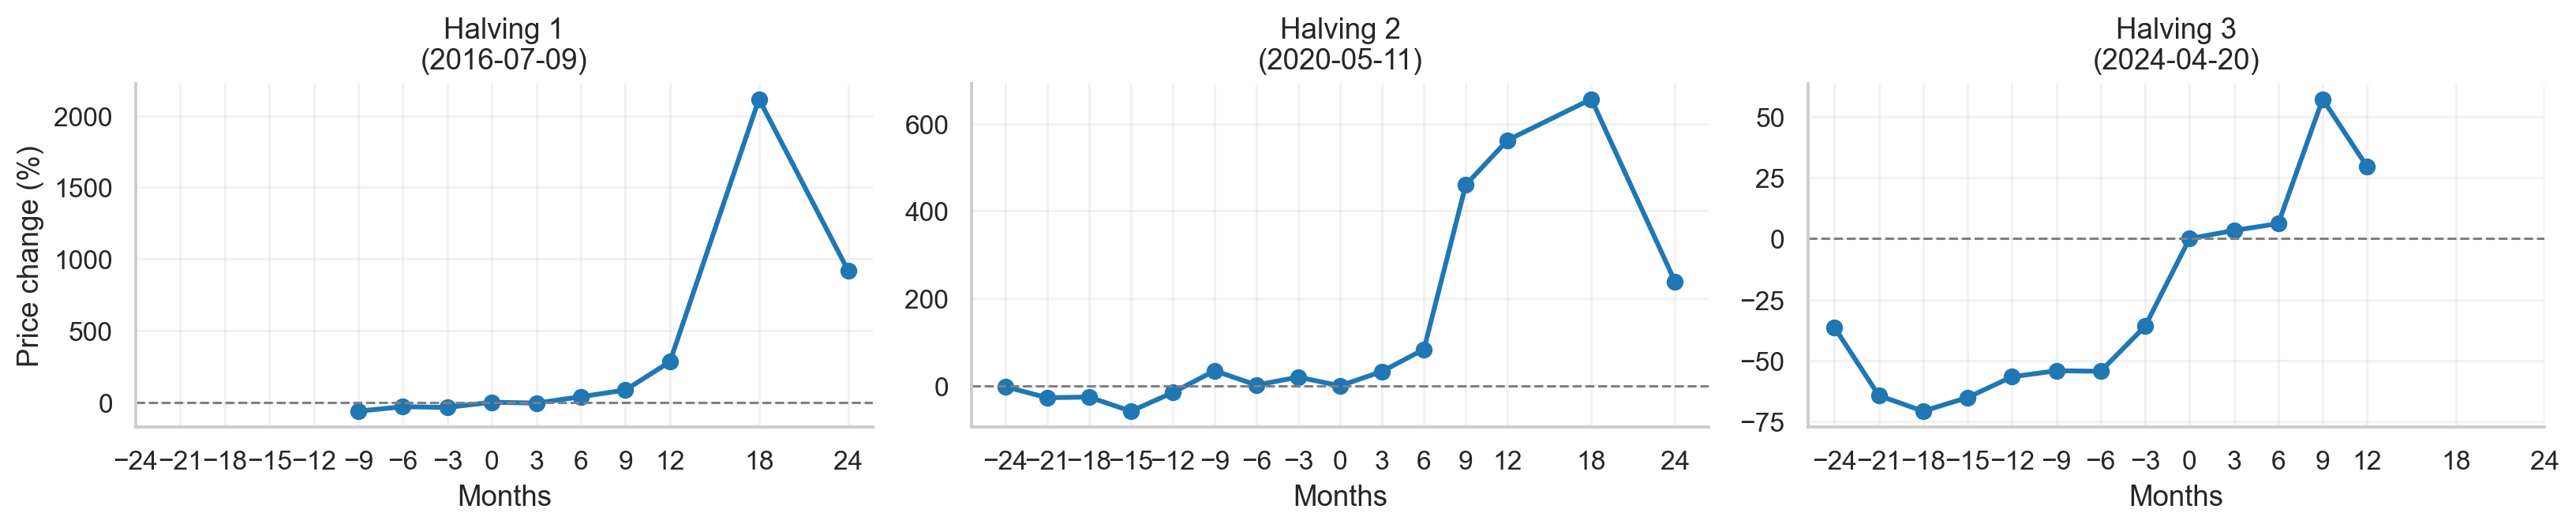

In [28]:
# ───────────── File paths & event info ───────────────────────────────────────
CSV_BTC   = r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version.csv"

HALVINGS  = [("2016-07-09", 1),
             ("2020-05-11", 2),
             ("2024-04-20", 3)]  # (date, event-id)

RET_MONTHS = list(range(-24, 13, 3)) + [12, 18, 24]  # explicitly include 12

# ───────────── Imports & plotting style ──────────────────────────────────────
import pandas as pd, numpy as np, re, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "figure.dpi": 220,
    "axes.spines.top": False,
    "axes.spines.right": False
})

# ───────────── Load daily close data ─────────────────────────────────────────
raw = pd.read_csv(Path(CSV_BTC))

tcol = next((c for c in raw.columns if re.search(r"(date|time|stamp)", c, re.I)), None)
if tcol is None:
    raise ValueError("timestamp column not found")

raw[tcol] = pd.to_datetime(raw[tcol], errors="coerce")
btc = (raw.dropna(subset=[tcol])
          .set_index(tcol)
          .sort_index())

close_d = btc["close"].astype(float).resample("1D").last().dropna()
latest_date = close_d.index.max()

# ───────────── Helper to fetch last available price ≤ timestamp ─────────────
def px(ts):
    idx = close_d.index.searchsorted(ts, side="right") - 1
    return close_d.iloc[idx] if idx >= 0 else np.nan

# ───────────── Clean halving dates defensively ───────────────────────────────
HALVINGS_CLEAN = [(re.sub(r"[^\d\-]", "-", d.strip()), eid) for d, eid in HALVINGS]

# ───────────── Build %‑change matrix ─────────────────────────────────────────
rows = []
for date_str, eid in HALVINGS_CLEAN:
    t0 = pd.Timestamp(date_str)
    p0 = px(t0)
    rec = {"event": eid, "T0": t0.date(), "P0": p0}
    for m in RET_MONTHS:
        t = t0 + pd.DateOffset(months=m)

        # Use +11m fallback if +12m is missing for 2024 halving
        if eid == 3 and m == 12 and (t > latest_date or pd.isna(px(t))):
            t = t0 + pd.DateOffset(months=11)
            print(f"⚠️ Using +11m as fallback for +12m (2024 halving): {t.date()}")

        if t > latest_date + pd.Timedelta(days=1) or t < close_d.index.min():
            print(f"⚠️ Skipping month {m:+} for event {eid} (out of range): {t}")
            continue

        rec[m] = px(t) / p0 - 1
    rows.append(rec)

df = (pd.DataFrame(rows)
        .set_index("event")
        .sort_index())

# ───────────── Plot all halving events side by side (1 row, 3 columns) ───────
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3), sharey=False)

for ax, (event_id, row) in zip(axes, df.iterrows()):
    months_all = sorted([k for k in row.index if isinstance(k, int)])
    ys = [row[m] * 100 for m in months_all]

    ax.plot(months_all, ys, marker="o", lw=2, color="tab:blue")
    ax.axhline(0, ls="--", color="gray", lw=1)
    ax.set_xticks(months_all)
    ax.set_xlabel("Months")
    ax.set_title(f"Halving {event_id}\n({row.T0})")
    ax.grid(alpha=0.25)

axes[0].set_ylabel("Price change (%)")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(top=0.88)
plt.show()


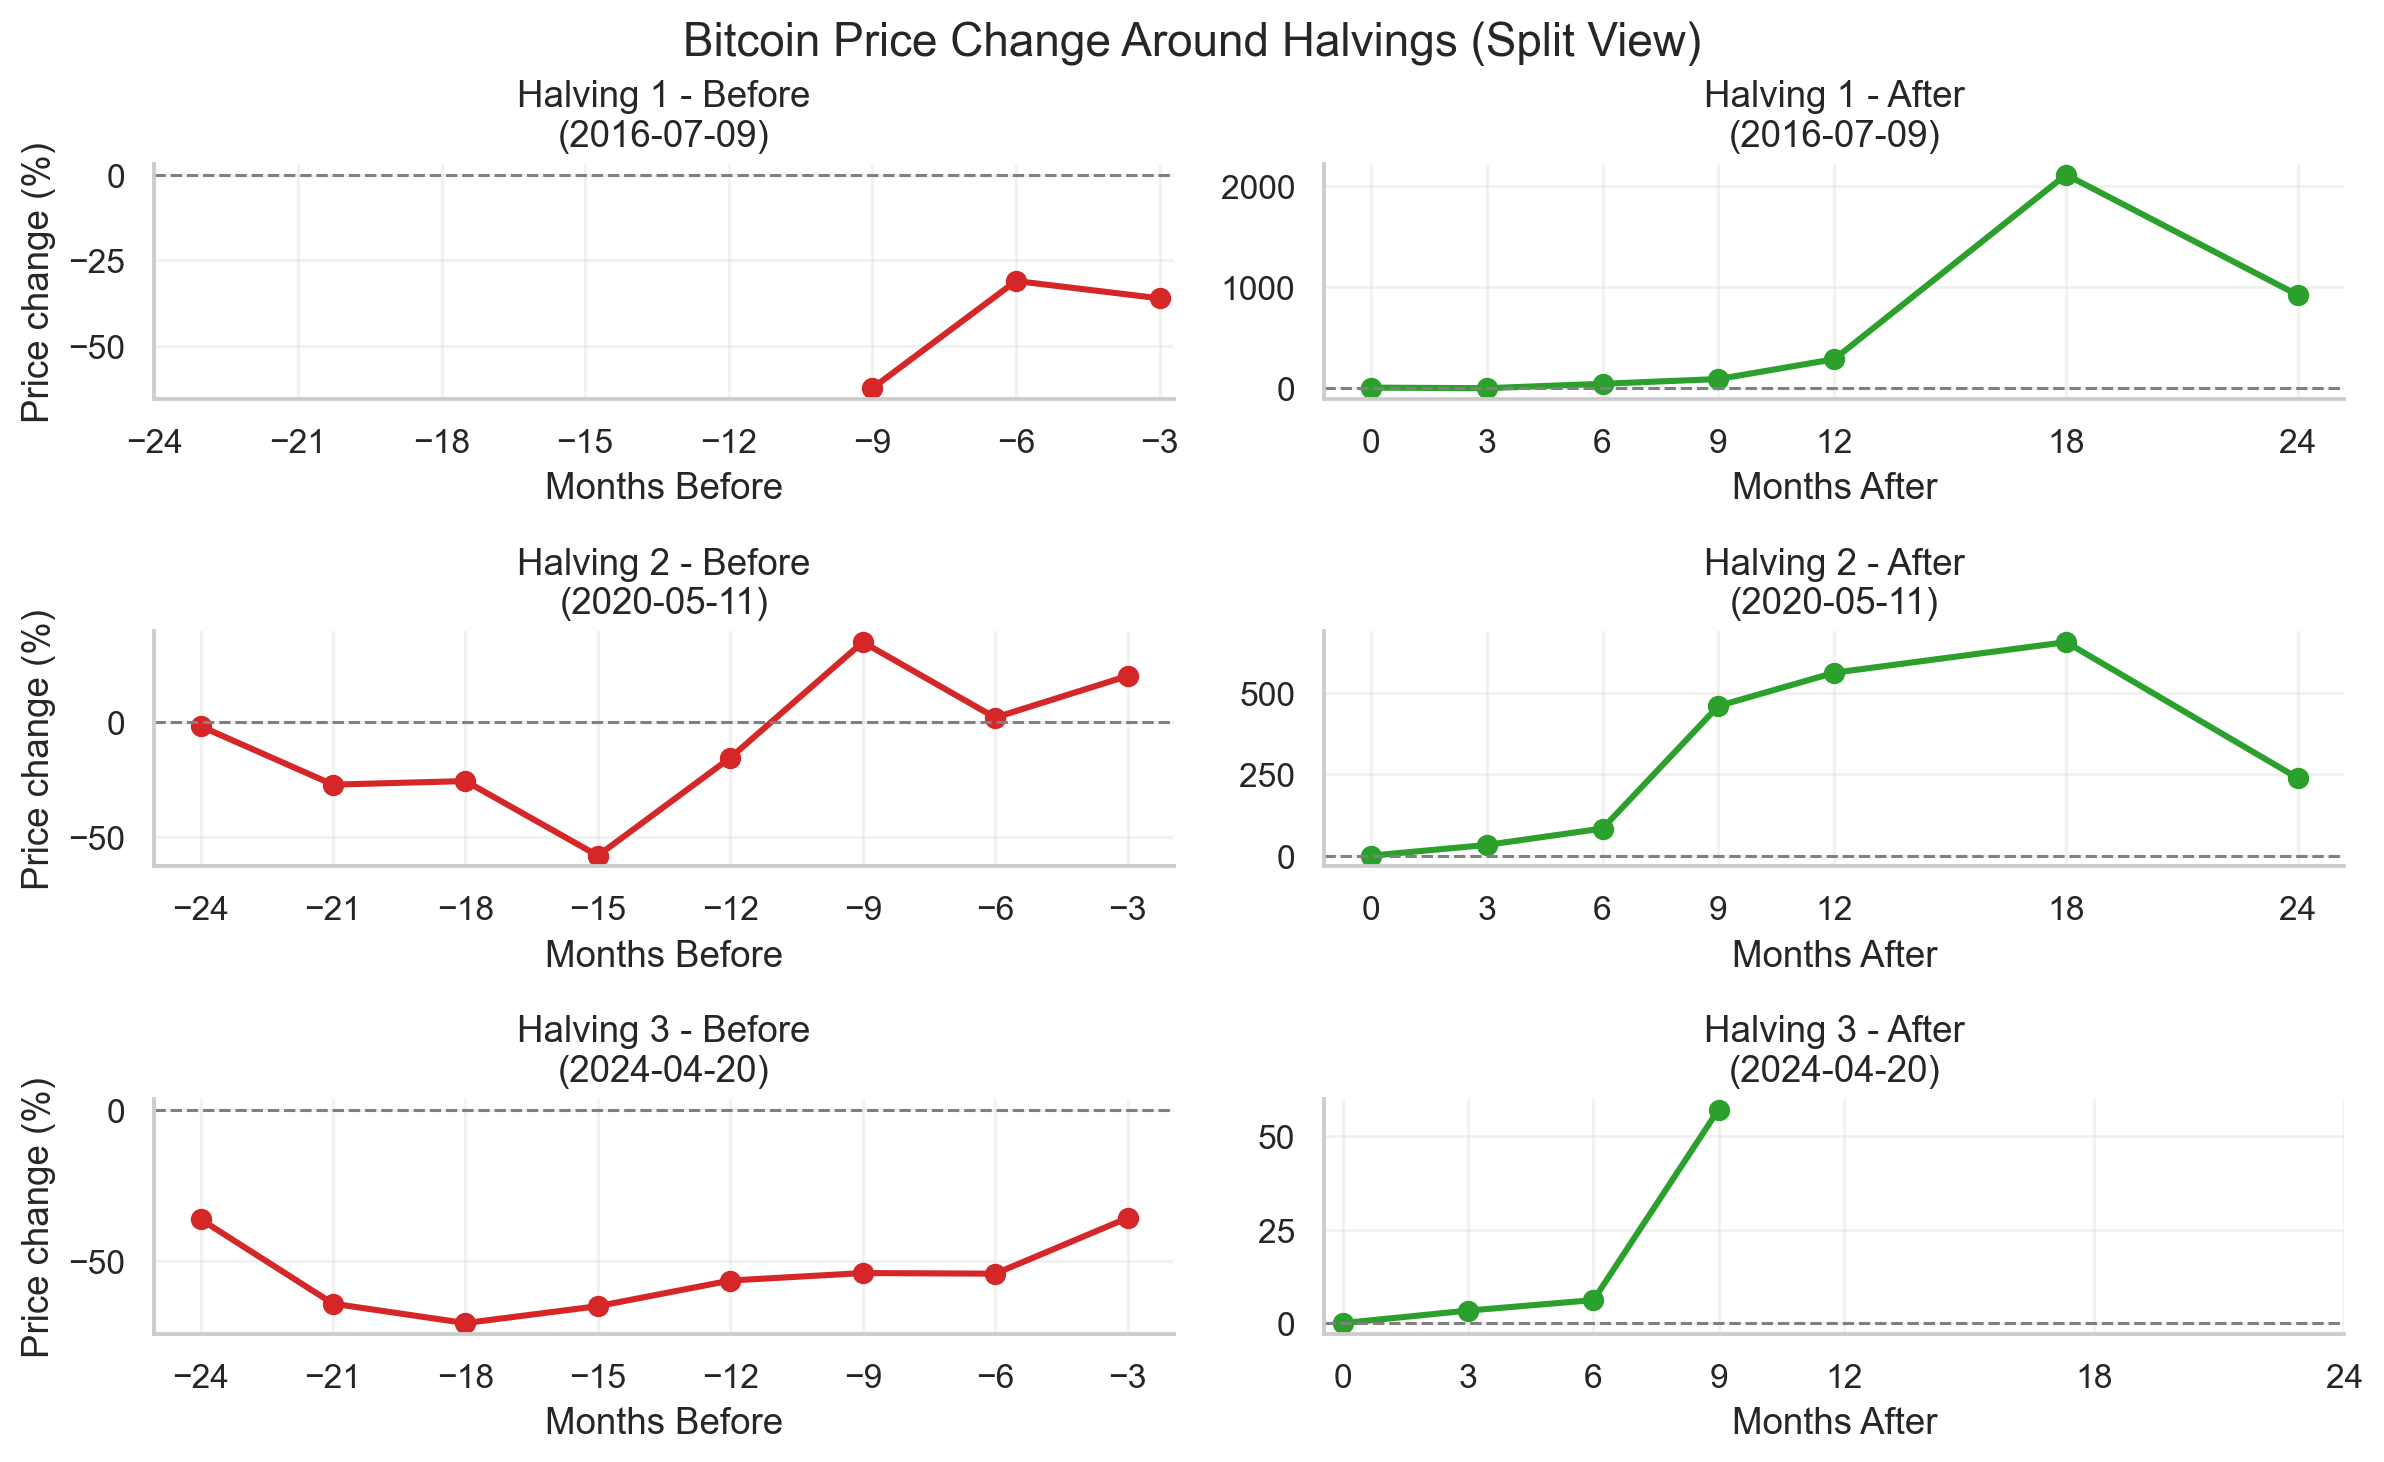

In [26]:
# ───────────── File paths & event info ───────────────────────────────────────
CSV_BTC   = r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version.csv"

HALVINGS  = [("2016-07-09", 1),
             ("2020-05-11", 2),
             ("2024-04-20", 3)]  # (date, event-id)

RET_MONTHS = list(range(-24, 13, 3)) + [18, 24]   # months before/after halving

# ───────────── Imports & plotting style ──────────────────────────────────────
import pandas as pd, numpy as np, re, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "figure.dpi": 220,
    "axes.spines.top": False,
    "axes.spines.right": False
})

# ───────────── Load daily close data ─────────────────────────────────────────
raw = pd.read_csv(Path(CSV_BTC))

tcol = next((c for c in raw.columns if re.search(r"(date|time|stamp)", c, re.I)), None)
if tcol is None:
    raise ValueError("timestamp column not found")

raw[tcol] = pd.to_datetime(raw[tcol], errors="coerce")
btc = (raw.dropna(subset=[tcol])
          .set_index(tcol)
          .sort_index())

close_d = btc["close"].astype(float).resample("1D").last().dropna()

# ───────────── Helper to fetch last available price ≤ timestamp ─────────────
def px(ts):
    idx = close_d.index.searchsorted(ts, side="right") - 1
    return close_d.iloc[idx] if idx >= 0 else np.nan

# ───────────── Clean halving dates defensively ───────────────────────────────
HALVINGS_CLEAN = [(re.sub(r"[^\d\-]", "-", d.strip()), eid) for d, eid in HALVINGS]

# ───────────── Build %‑change matrix ─────────────────────────────────────────
rows = []
for date_str, eid in HALVINGS_CLEAN:
    t0 = pd.Timestamp(date_str)
    p0 = px(t0)
    rec = {"event": eid, "T0": t0.date(), "P0": p0}
    for m in RET_MONTHS:
        t = t0 + pd.DateOffset(months=m)
        if t > close_d.index.max() or t < close_d.index.min():
            continue
        rec[m] = px(t) / p0 - 1
    rows.append(rec)

df = (pd.DataFrame(rows)
        .set_index("event")
        .sort_index())

# ───────────── Plot each halving in 2 panels: before and after ───────────────
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(11, 6.5))

for row_idx, (event_id, row) in enumerate(df.iterrows()):
    months_all = sorted([k for k in row.index if isinstance(k, int)])
    ys_all = {m: row[m] * 100 for m in months_all}

    # Before halving
    xs_before = [m for m in months_all if m < 0]
    ys_before = [ys_all[m] for m in xs_before]
    ax_before = axes[row_idx, 0]
    ax_before.plot(xs_before, ys_before, marker="o", lw=2, color="tab:red")
    ax_before.axhline(0, ls="--", color="gray", lw=1)
    ax_before.set_xticks(xs_before)
    ax_before.set_title(f"Halving {event_id} - Before\n({row.T0})")
    ax_before.set_xlabel("Months Before")
    ax_before.set_ylabel("Price change (%)")
    ax_before.grid(alpha=0.25)

    # After halving
    xs_after = [m for m in months_all if m >= 0]
    ys_after = [ys_all[m] for m in xs_after]
    ax_after = axes[row_idx, 1]
    ax_after.plot(xs_after, ys_after, marker="o", lw=2, color="tab:green")
    ax_after.axhline(0, ls="--", color="gray", lw=1)
    ax_after.set_xticks(xs_after)
    ax_after.set_title(f"Halving {event_id} - After\n({row.T0})")
    ax_after.set_xlabel("Months After")
    ax_after.grid(alpha=0.25)

plt.tight_layout()
plt.suptitle("Bitcoin Price Change Around Halvings (Split View)", fontsize=15, y=1.02)
plt.subplots_adjust(top=0.92)
plt.show()


# Adding bitcoin halving feature

# Cell 0 – Title & notebook roadmap
This notebook tests whether a “distance-to-halving” signal
improves BTC-price predictions.

**Experiment plan**

| Stage | What we do |
|-------|------------|
| 1 | Load data & parse `date` |
| 2 | Engineer `cycle_phase` (0 → day of halving, 1 → day before next halving) |
| 3 | Train a baseline RandomForest (no halving info) and one with `cycle_phase` |
| 4 | Add `cycle_phase_sin/cos` (Option 2) and re-benchmark |
| 5 | Inspect feature importances |


In [ ]:
# Cell 1 – Imports & load
import pandas as pd, numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier      # ← add / re-run

FEATURES_BASE  = ["open", "high", "low", "Volume BTC"]
...


CSV = r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version.csv"
df  = (
    pd.read_csv(CSV, parse_dates=["date"])
      .sort_values("date")
      .reset_index(drop=True)
)

print(f"{len(df):,} rows  {df['date'].min().date()} → {df['date'].max().date()}")
df.head()


82,519 rows  2015-10-08 → 2025-03-27


,date,open,high,low,close,Volume BTC
0,2015-10-08 14:00:00,245.00,245.00,244.50,245.00,4.453649
1,2015-10-08 15:00:00,245.00,245.00,244.92,244.92,3.016926
2,2015-10-08 16:00:00,244.92,244.92,244.25,244.25,3.895252
3,2015-10-08 17:00:00,244.25,244.99,244.02,244.99,3.920632
4,2015-10-08 18:00:00,244.99,244.99,244.00,244.00,3.690472


In [ ]:
# Cell 2 – Halving calendar & features
HALVINGS = pd.to_datetime(["2012-11-28","2016-07-09","2020-05-11","2024-04-20"])
NEXT_EST = pd.to_datetime("2028-03-31")          # 5th (proj.)
CYCLE_ENDS = pd.Index(list(HALVINGS[1:]) + [NEXT_EST])

def cycle_phase(ts):
    idx = np.searchsorted(HALVINGS, ts, side="right") - 1
    if idx < 0:
        return np.nan
    return (ts - HALVINGS[idx]).days / (CYCLE_ENDS[idx] - HALVINGS[idx]).days

df["cycle_phase"]      = df["date"].apply(cycle_phase)
df["cycle_phase_sin"]  = np.sin(2*np.pi*df["cycle_phase"])
df["cycle_phase_cos"]  = np.cos(2*np.pi*df["cycle_phase"])
df.head()


,date,open,high,low,close,Volume BTC,cycle_phase,cycle_phase_sin,cycle_phase_cos
0,2015-10-08 14:00:00,245.00,245.00,244.50,245.00,4.453649,0.791509,-0.966182,0.25786
1,2015-10-08 15:00:00,245.00,245.00,244.92,244.92,3.016926,0.791509,-0.966182,0.25786
2,2015-10-08 16:00:00,244.92,244.92,244.25,244.25,3.895252,0.791509,-0.966182,0.25786
3,2015-10-08 17:00:00,244.25,244.99,244.02,244.99,3.920632,0.791509,-0.966182,0.25786
4,2015-10-08 18:00:00,244.99,244.99,244.00,244.00,3.690472,0.791509,-0.966182,0.25786


In [22]:
# Cell 2 – Halving calendar & features
HALVINGS = pd.to_datetime(["2012-11-28","2016-07-09","2020-05-11","2024-04-20"])
NEXT_EST = pd.to_datetime("2028-03-31")          # 5th (proj.)
CYCLE_ENDS = pd.Index(list(HALVINGS[1:]) + [NEXT_EST])

def cycle_phase(ts):
    idx = np.searchsorted(HALVINGS, ts, side="right") - 1
    if idx < 0:
        return np.nan
    return (ts - HALVINGS[idx]).days / (CYCLE_ENDS[idx] - HALVINGS[idx]).days

df["cycle_phase"]      = df["date"].apply(cycle_phase)
df["cycle_phase_sin"]  = np.sin(2*np.pi*df["cycle_phase"])
df["cycle_phase_cos"]  = np.cos(2*np.pi*df["cycle_phase"])
df.head()


,date,open,high,low,close,Volume BTC,cycle_phase,cycle_phase_sin,cycle_phase_cos
0,2015-10-08 14:00:00,245.00,245.00,244.50,245.00,4.453649,0.791509,-0.966182,0.25786
1,2015-10-08 15:00:00,245.00,245.00,244.92,244.92,3.016926,0.791509,-0.966182,0.25786
2,2015-10-08 16:00:00,244.92,244.92,244.25,244.25,3.895252,0.791509,-0.966182,0.25786
3,2015-10-08 17:00:00,244.25,244.99,244.02,244.99,3.920632,0.791509,-0.966182,0.25786
4,2015-10-08 18:00:00,244.99,244.99,244.00,244.00,3.690472,0.791509,-0.966182,0.25786


In [23]:
# Cell 3 – Create direction label (1 = next close up)
df["close_fwd"] = df["close"].shift(-1)
df = df.dropna(subset=["close_fwd"]).reset_index(drop=True)

df["direction"] = (df["close_fwd"] > df["close"]).astype(int)
df["direction"].value_counts()


direction
1    41472
0    41046
Name: count, dtype: int64

In [24]:
# Cell 3 – Create direction label (1 = next close up)
df["close_fwd"] = df["close"].shift(-1)
df = df.dropna(subset=["close_fwd"]).reset_index(drop=True)

df["direction"] = (df["close_fwd"] > df["close"]).astype(int)
df["direction"].value_counts()


direction
1    41472
0    41045
Name: count, dtype: int64

In [25]:
# Cell 4 – Helper to train / test RF on time-ordered split
FEATURES_BASE  = ["open", "high", "low", "Volume BTC"]
FEATURES_OPT1  = FEATURES_BASE + ["cycle_phase"]
FEATURES_OPT2  = FEATURES_BASE + ["cycle_phase","cycle_phase_sin","cycle_phase_cos"]

def quick_clf(cols):
    split = int(0.8 * len(df))                     # 80 % train, 20 % test
    X_train, y_train = df.loc[:split-1, cols], df.loc[:split-1, "direction"]
    X_test , y_test  = df.loc[split:,   cols], df.loc[split:,   "direction"]

    clf = RandomForestClassifier(
        n_estimators=300, max_depth=None, n_jobs=-1, random_state=42
    ).fit(X_train, y_train)

    acc = accuracy_score(y_test, clf.predict(X_test))
    return clf, acc, y_test, clf.predict(X_test)

# --- Baseline
_, acc_base, _, _ = quick_clf(FEATURES_BASE)
print(f"Baseline accuracy          : {acc_base:.3%}")

# --- Option 1
_, acc_opt1, _, _ = quick_clf(FEATURES_OPT1)
print(f"Option 1 (+cycle_phase)    : {acc_opt1:.3%}")

# --- Option 2
clf_opt2, acc_opt2, y_test_opt2, pred_opt2 = quick_clf(FEATURES_OPT2)
print(f"Option 2 (+sin/cos)        : {acc_opt2:.3%}")


Baseline accuracy          : 50.194%
Option 1 (+cycle_phase)    : 49.594%
Option 2 (+sin/cos)        : 49.206%


In [26]:
# Cell 5 – Confusion matrix for the best option
print("\nBest accuracy =", max(acc_base, acc_opt1, acc_opt2))
cm = confusion_matrix(y_test_opt2, pred_opt2)
cr = classification_report(y_test_opt2, pred_opt2, digits=3)
print("\nConfusion matrix (Option 2):\n", cm)
print("\nClassification report:\n", cr)



Best accuracy = 0.501938923897237

Confusion matrix (Option 2):
 [[7553  534]
 [7849  568]]

Classification report:
               precision    recall  f1-score   support

           0      0.490     0.934     0.643      8087
           1      0.515     0.067     0.119      8417

    accuracy                          0.492     16504
   macro avg      0.503     0.501     0.381     16504
weighted avg      0.503     0.492     0.376     16504

